**Network Science**

**Project Descriptive analysis of a social network**

By Sahil

In [ ]:
!pip install telethon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.8/599.8 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for telethon: filename=Telethon-1.35.0-py3-none-any.whl size=675107 sha256=8f3210199ae9cfa62bc9b144864c757c3edeac9dbdd48e20d7df029a10ec742c
  Stored in directory: /root/.cache/pip/wheels/7b/18/81/4a5a3adfd4af392db743a5a5942157c220bbedda57a17d6bbf
  Created wheel for pyaes: filename=pyaes-1.6.1-py3-none-any.whl size=26347 sha256=097bd3b84692199cc4341ac61c4352b7c8e2d588da0a9036e4d01be6c2bc2d4d
  Stored in directory: /root/.cache/pip/wheels/d6/84/5f/ea6aef85a93c7e1922486369874f4740a5642d261e09c59140
Successfully built telethon pyaes


In [1]:
import configparser
import json
import asyncio
import pandas as pd
import nest_asyncio
import csv
import networkx as nx
import time
from datetime import date, datetime
import matplotlib.pyplot as plt
import operator
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import numpy as np
from scipy.optimize import minimize
from scipy.stats import kstest
from sklearn.linear_model import LinearRegression
from scipy import stats
import matplotlib.colors as mcolors
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.special import zeta
from scipy.stats import ks_2samp
from scipy.spatial.distance import jensenshannon


from telethon import TelegramClient
from telethon.errors.rpcerrorlist import FloodWaitError
from telethon.errors import SessionPasswordNeededError
from telethon.tl.functions.channels import GetParticipantsRequest
from telethon.tl.types import ChannelParticipantsSearch
from telethon.tl.functions.messages import GetDialogsRequest
from telethon.tl.types import PeerUser
from telethon.tl.types import ChannelParticipantsSearch, PeerChannel
from telethon.tl.functions.messages import (GetHistoryRequest)

from telethon.tl.types import (
    PeerChannel
)

**Configuration Values**

To interact with the Telegram API using the Telethon library, several configuration values are required. These include the api_id, api_hash, phone, and optionally username. These values are used to authenticate your client with the Telegram servers.

api_id: This is a unique identifier for your application. It is obtained by registering your application on the Telegram API development portal.

api_hash: This is a unique hash associated with your api_id. It acts as a secret key that, along with the api_id, authenticates your application with the Telegram servers.

phone: This is the phone number associated with your Telegram account. It is used to verify your identity and log in to your account.

username: This is the username associated with your Telegram account. While not strictly necessary for authentication, it can be useful for referencing your account in code.



In [ ]:
# Setting configuration values
api_id = 542XXXX
api_hash = "a9cad832gss362eb05bbasdgecXXXXX"
# api_hash = str(a9cad81f31362eb05bba0d3c9990c64c)
phone = "+7926307XXXXX"
username = "sahilXXX"

The TelegramClient is initialized with your username, api_id, and api_hash. The username acts as an identifier for the session file, which stores your session data locally. This means you won’t need to re-enter your credentials every time you run your script, making subsequent authentications faster and more seamless.

In [ ]:
# Create the client and connect
client = TelegramClient(username, api_id, api_hash)

chat_id: The unique identifier of the chat you want to interact with.

For the given project I have used the channel MarCoders (https://t.me/MarCoders)

Little description about this community

"Welcome to our vibrant community of passionate coders and developers!
Connect with like minded individuals, share knowledge, collaborate on projects.

Send us your constructive feedbacks @MarCodersFeedbackBot

Resources @MarCodersLibrary"

In [ ]:
chat_id = 1002142642757


**DateTimeEncoder Class for JSON Serialization**


The DateTimeEncoder class is a custom JSON encoder designed to handle the serialization of datetime objects and bytes objects, which are not natively serializable by the default JSON encoder in Python. This class extends json.JSONEncoder and overrides the default method to provide custom serialization logic.


In [ ]:
# some functions to parse json date
class DateTimeEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, datetime):
            return o.isoformat()

        if isinstance(o, bytes):
            return list(o)

        return json.JSONEncoder.default(self, o)


**Reading Configurations using configparser**


The configparser module in Python allows us to easily read configuration files in INI format. These configuration files typically contain key-value pairs organized into sections, making them suitable for storing application settings, parameters, or other configuration data.

In [ ]:
# Reading Configs
config = configparser.ConfigParser()
config.read("config.ini")


[]

This async function `main()` performs the following tasks:

1. **Client Connection**: It establishes a connection with the Telegram client using `await client.start()`. If the user is not already authorized, it sends a code request to the provided phone number and signs in with the received code or password.

2. **Input Channel Entity**: It prompts the user to enter the entity (either a Telegram URL or entity ID) representing the channel from which messages will be fetched. Based on the input, it gets the entity object using `await client.get_entity()`.

3. **Fetching Messages**: It continuously retrieves messages from the specified channel using the `GetHistoryRequest` method. The parameters of this method determine the range and number of messages to be fetched. It iterates over the fetched messages, adds them to a list (`all_messages`), and updates the offset ID for the next request.

4. **Saving Messages to JSON**: Once all messages are fetched, it writes the list of message dictionaries to a JSON file named "channel_messages.json" using `json.dump()`.

5. **Execution**: Finally, it executes the `main()` function by awaiting its completion.

This function is designed to fetch messages from a specified Telegram channel and store them in a JSON file for further processing or analysis.

In [ ]:
async def main(phone):
    await client.start()
    print("Client Created")
    # Ensure you''re authorized
    if await client.is_user_authorized() == False:
        await client.send_code_request(phone)
        try:
            await client.sign_in(phone, input("Enter the code: "))
        except SessionPasswordNeededError:
            await client.sign_in(password=input("Password: "))

    me = await client.get_me()

    user_input_channel = input("enter entity(telegram URL or entity id):")

    if user_input_channel.isdigit():
        entity = PeerChannel(int(user_input_channel))
    else:
        entity = user_input_channel

    my_channel = await client.get_entity(entity)

    offset_id = 0
    limit = 1000
    all_messages = []
    total_messages = 1000
    total_count_limit = 0

    while True:
        print("Current Offset ID is:", offset_id, "; Total Messages:", total_messages)
        history = await client(GetHistoryRequest(
            peer=my_channel,
            offset_id=offset_id,
            offset_date=None,
            add_offset=0,
            limit=limit,
            max_id=0,
            min_id=0,
            hash=0
        ))
        if not history.messages:
            break
        messages = history.messages
        for message in messages:
            all_messages.append(message.to_dict())
        offset_id = messages[len(messages) - 1].id
        total_messages = len(all_messages)
        if total_count_limit != 0 and total_messages >= total_count_limit:
            break

    with open("channel_messages.json", "w") as outfile:
        json.dump(all_messages, outfile, cls=DateTimeEncoder)

await main(phone)

Client Created
enter entity(telegram URL or entity id):https://t.me/MarCoders
Current Offset ID is: 0 ; Total Messages: 1000
Current Offset ID is: 2712 ; Total Messages: 100
Current Offset ID is: 2601 ; Total Messages: 200
Current Offset ID is: 2476 ; Total Messages: 300
Current Offset ID is: 2358 ; Total Messages: 400
Current Offset ID is: 2249 ; Total Messages: 500
Current Offset ID is: 2127 ; Total Messages: 600
Current Offset ID is: 2002 ; Total Messages: 700
Current Offset ID is: 1860 ; Total Messages: 800
Current Offset ID is: 1725 ; Total Messages: 900
Current Offset ID is: 1507 ; Total Messages: 1000
Current Offset ID is: 1273 ; Total Messages: 1100
Current Offset ID is: 1157 ; Total Messages: 1200
Current Offset ID is: 1042 ; Total Messages: 1300
Current Offset ID is: 934 ; Total Messages: 1400
Current Offset ID is: 823 ; Total Messages: 1500
Current Offset ID is: 690 ; Total Messages: 1600
Current Offset ID is: 560 ; Total Messages: 1700
Current Offset ID is: 428 ; Total Mess

This code snippet performs the following tasks:

1. **Loading JSON Data**: It opens the JSON file "channel_messages.json" in read mode using a `with` statement and loads its contents into a Python object named `messages` using `json.load()`.

2. **Fetching an Example Message**: It checks if there are any messages loaded from the JSON file. If messages are found (`if messages:`), it selects the first message from the loaded data (`messages[0]`) as an example and assigns it to the variable `example_message`.

3. **Printing Example Message**: It prints the example message with indentation for readability using `json.dumps()`.

This code helps in quickly examining the structure and content of the messages stored in the JSON file by displaying an example message.

In [49]:
# Load data from JSON file
with open("channel_messages.json", "r") as file:
    messages = json.load(file)

# Fetch a single message from the loaded data
if messages:
    example_message = messages[0]  # Fetch the first message as an example
    print("Example message:")
    print(json.dumps(example_message, indent=4))  # Print the example message with indentation for readability
else:
    print("No messages found in the JSON file.")


The example message fetched from the `channel_messages.json` file contains various fields that provide detailed information about the message. Here's an explanation of each field:

- **_**: The type of the object, in this case, "Message".
- **id**: The unique identifier of the message (2866).
- **peer_id**: The ID of the channel where the message was posted.
  - **_**: The type of the peer object, in this case, "PeerChannel".
  - **channel_id**: The unique identifier of the channel (2142642757).
- **date**: The timestamp when the message was sent ("2024-05-22T20:49:22+00:00").
- **message**: The content of the message.
- **out**: Indicates whether the message was sent by the logged-in user (false).
- **mentioned**: Indicates whether the message mentions the logged-in user (false).
- **media_unread**: Indicates whether there is unread media (false).
- **silent**: Indicates whether the message was sent silently (false).
- **post**: Indicates whether the message is a post (false).
- **from_scheduled**: Indicates whether the message was scheduled (false).
- **legacy**: Indicates whether the message is a legacy message (false).
- **edit_hide**: Indicates whether the edit date is hidden (false).
- **pinned**: Indicates whether the message is pinned (false).
- **noforwards**: Indicates whether the message cannot be forwarded (false).
- **invert_media**: Indicates whether the media is inverted (false).
- **offline**: Indicates whether the message was sent offline (false).
- **from_id**: The ID of the user who sent the message (null, because it's a channel message).
- **fwd_from**: Information about the forwarded message (null).
- **via_bot_id**: The ID of the bot through which the message was sent (null).
- **reply_to**: Information about the message this message is replying to (null).
- **media**: The media attached to the message (null).
- **reply_markup**: The markup for the reply buttons (null).
- **entities**: A list of entities (e.g., URLs, mentions) in the message text.
  - **_**: The type of the entity (e.g., "MessageEntityCustomEmoji").
  - **offset**: The position where the entity starts in the message text.
  - **length**: The length of the entity in the message text.
  - **document_id**: The ID of the custom emoji document.
  - **url**: The URL associated with the entity.
- **views**: The number of views the message has (null).
- **forwards**: The number of times the message was forwarded (null).
- **replies**: Information about the replies to the message.
  - **_**: The type of the replies object, in this case, "MessageReplies".
  - **replies**: The number of replies (0).
  - **replies_pts**: The points related to replies (4728).
  - **comments**: Indicates whether there are comments (false).
  - **recent_repliers**: List of recent repliers (empty).
- **edit_date**: The date when the message was edited (null).
- **post_author**: The author of the post ("MarCoders").
- **grouped_id**: The ID of the group of messages (null).
- **reactions**: Reactions to the message (null).
- **restriction_reason**: List of restriction reasons (empty).
- **ttl_period**: Time-to-live period for the message (null).
- **quick_reply_shortcut_id**: Quick reply shortcut ID (null).

### Example Explanation

This message was sent to the "MarCoders" channel and contains an announcement for a free training session. The message includes information about the date and time of the training, the speaker, and a link to the speaker's LinkedIn profile. There are several entities within the message, including a custom emoji, bold text, and URLs. The message is not pinned, not forwarded, and has no media attached. There are no replies or reactions to this message. The author of the post is "MarCoders".

This detailed structure provides rich information that can be used for various purposes, such as analyzing the content, understanding user interactions, and extracting metadata for further processing.

This code snippet performs the following tasks:

1. **Loading JSON Data**: It opens the JSON file "channel_messages.json" in read mode using a `with` statement and loads its contents into a Python object named `messages` using `json.load()`.

2. **Creating a Directed Graph**: It initializes a directed graph `G` using NetworkX's `DiGraph()` function. This graph will be used to represent the communication network, where nodes represent users and edges represent messages.

In [94]:
# Load data from JSON file
with open("channel_messages.json", "r") as file:
    messages = json.load(file)

# Create a directed graph
G = nx.DiGraph()

This code snippet parses the messages loaded from the JSON file and creates nodes and edges in the directed graph `G` based on the message data. Here's what it does:

1. **Extracting Sender Information**: It retrieves the sender's ID from each message. If the sender's ID is not present or cannot be determined, the message is skipped.

2. **Adding Nodes**: It adds a node to the graph for each sender found in the messages.

3. **Creating Edges for Replies**: For each message, it checks if the message is a reply to another message. If so, it finds the user who sent the replied message and creates an edge from the sender of the current message to the sender of the replied message.

4. **Creating Edges for Mentions**: It looks for mentions in each message and creates edges from the sender of the message to the mentioned users. For simplicity, it assumes that mentioned usernames are valid user IDs and adds edges accordingly.

This process helps construct a communication network represented by the directed graph `G`, where nodes represent users and edges represent communication interactions such as replies and mentions.

In [95]:
# Parse messages to create nodes and edges
for message in messages:
    from_id_info = message.get('from_id', None)
    if not from_id_info:
        continue  # Skip messages without a valid sender

    # Extract the user ID from 'from_id' field
    if isinstance(from_id_info, dict):
        from_id = from_id_info.get('user_id')
    else:
        from_id = from_id_info

    if not from_id:
        continue  # Skip if 'from_id' is still not valid

    # Add the sender as a node
    G.add_node(from_id)

    # Add edges for replies
    reply_to = message.get('reply_to', None)
    if reply_to:
        replied_message_id = reply_to.get('reply_to_msg_id', None)
        if replied_message_id:
            # Find the user who sent the replied message
            for msg in messages:
                if msg['id'] == replied_message_id:
                    to_id_info = msg.get('from_id', None)
                    if to_id_info:
                        if isinstance(to_id_info, dict):
                            to_id = to_id_info.get('user_id')
                        else:
                            to_id = to_id_info
                        if to_id:
                            G.add_edge(from_id, to_id)

    # Add edges for mentions
    entities = message.get('entities', [])
    for entity in entities:
        if entity['_'] == 'MessageEntityMention':
            mentioned_username = message['message'][entity['offset']:entity['offset'] + entity['length']]
            # Here, you may need to map mentioned usernames to user IDs if possible
            # For simplicity, we'll assume the mentioned username is a valid user ID
            G.add_edge(from_id, mentioned_username)


In [96]:
# Ensure network size is at least 300 nodes
if len(G) < 300:
    print("The network has less than 300 nodes. The size is:", len(G))
else:
    print("The network size is:", len(G))

# Save the graph to a file for further analysis if needed
nx.write_gexf(G, "communication_network.gexf")



The network size is: 383


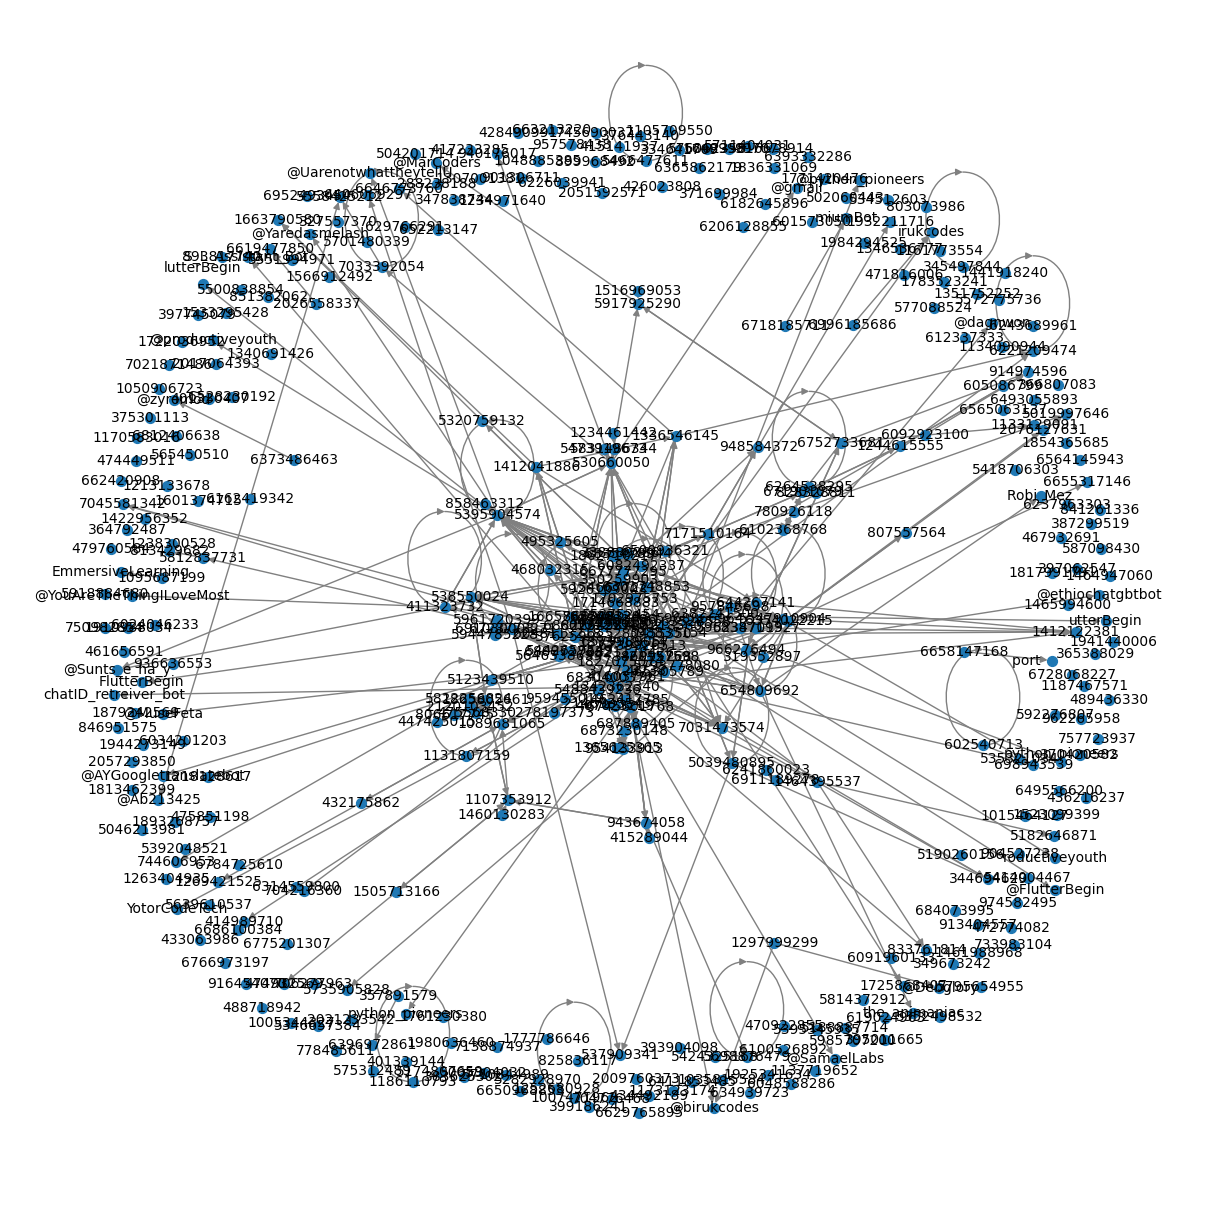

In [97]:
# Draw the graph (optional, for visualization purposes)
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=10, edge_color='gray')
plt.show()

In [98]:
# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print out the graph statistics
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Graph size: {num_edges}")
print(f"Graph order: {num_nodes}")


Number of nodes: 383
Number of edges: 418
Graph size: 418
Graph order: 383


This code snippet analyzes the network represented by the graph `G` and visualizes an ego graph centered around the node with the highest degree. Let's break down the code:

1. **Identifying the Node with the Highest Degree**:
   - The `sorted(G.degree(), key=operator.itemgetter(1))` sorts the nodes in the graph `G` based on their degrees in ascending order.
   - `node_and_degree[-1]` selects the node with the highest degree from the sorted list.
   - `largest_hub, degree = node_and_degree[-1]` unpacks the node ID and its degree.
   - Finally, it prints the ID and degree of the largest hub.

2. **Creating an Ego Graph**:
   - `hub_ego = nx.ego_graph(G, largest_hub)` creates an ego graph centered around the largest hub node identified earlier. An ego graph contains the specified node (the "ego") and its neighbors.

3. **Plotting the Ego Graph**:
   - `plt.figure(figsize=(8, 5))` sets the size of the plot.
   - `pos = nx.spring_layout(hub_ego)` defines the layout for the plot using the spring layout algorithm.
   - `nx.draw(hub_ego, pos, node_color="orange", node_size=70, with_labels=False)` draws the ego graph. It sets the node color to orange, node size to 70, and hides node labels (`with_labels=False`).
   
4. **Displaying the Plot**:
   - `plt.show()` displays the plot.


This code effectively identifies the node with the highest degree in the network and visualizes an ego graph centered around that node. Ego graphs provide insights into the local structure around a specific node, highlighting its immediate neighborhood within the larger network.

Largest hub ID: 6677777295 with degree 30


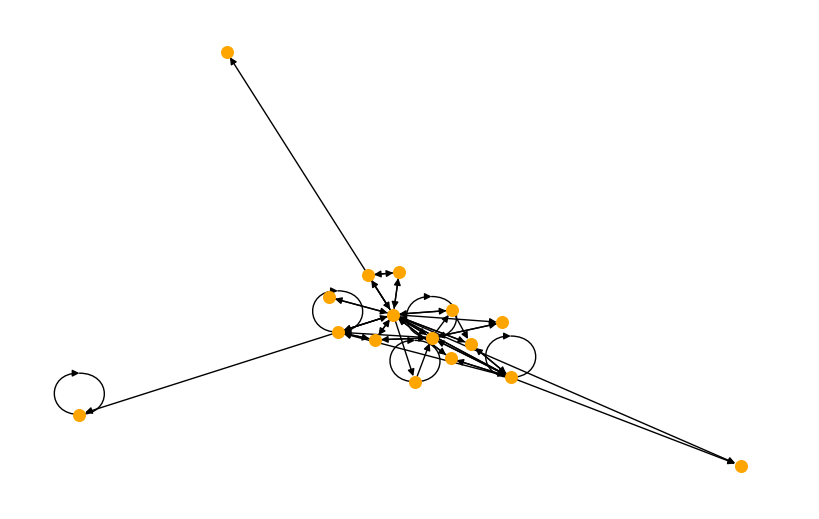

In [99]:


# Get the node with the highest degree
node_and_degree = sorted(G.degree(), key=operator.itemgetter(1))
largest_hub, degree = node_and_degree[-1]
print(f"Largest hub ID: {largest_hub} with degree {degree}")

# Create an ego graph centered around the largest hub
hub_ego = nx.ego_graph(G, largest_hub)

# Set the figure size for the plot
plt.figure(figsize=(8, 5))

# Define the layout for the plot
pos = nx.spring_layout(hub_ego)

# Draw the graph
nx.draw(hub_ego, pos, node_color="orange", node_size=70, with_labels=False)

# Show the plot
plt.show()


Largest hub ID: 6677777295, Degree: 30


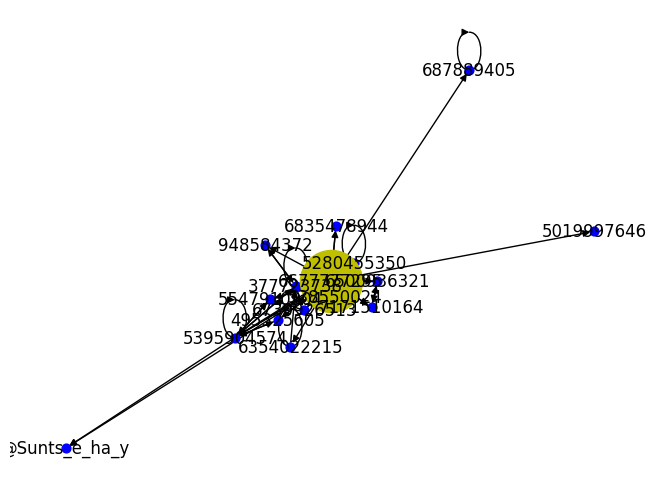

In [100]:
# Get the node with the highest degree
node_and_degree = G.degree()
largest_hub, degree = sorted(node_and_degree, key=operator.itemgetter(1))[-1]
print(f"Largest hub ID: {largest_hub}, Degree: {degree}")

# Create an ego graph centered around the largest hub
hub_ego = nx.ego_graph(G, largest_hub)

# Draw the ego graph with small blue nodes
pos = nx.spring_layout(hub_ego)
nx.draw(hub_ego, pos, node_color="b", node_size=40, with_labels=True)

# Draw the largest hub with a large yellow node
options = {"node_size": 2000, "node_color": "y"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], **options)

# Show the plot
plt.show()

The communication network extracted from the Telegram channel data can be characterized as a **directed** and **homogeneous** graph.

- **Directed Graph**: This indicates that the relationships between users, represented by the edges in the graph, have a direction. In this context, edges represent the flow of communication, where messages are sent from one user (the source) to another user (the target).

- **Homogeneous Graph**: All nodes in the graph represent users, and they share the same type of relationship, which is communication. There are no different types of nodes or edges in the graph; all nodes represent users engaging in communication within the Telegram channel.

Moreover, the graph can be considered **unweighted** since no weights are associated with the edges. Each edge represents a single communication event between users without any additional quantitative significance.

This characterization provides insights into the nature of the communication network extracted from the Telegram channel data, laying the foundation for further analysis and interpretation of the interactions among users within the channel.

This code snippet loads JSON data from a file named "channel_messages.json", extracts sender IDs and mentioned users from the messages, and then initializes dictionaries to store node and edge attributes based on the extracted information. Let's break down the code:

1. **Loading JSON Data**:
   - `with open("channel_messages.json", "r") as file:` opens the JSON file in read mode.
   - `messages = json.load(file)` loads the JSON data from the file into the `messages` variable.

2. **Extracting Attributes from Messages**:
   - The code iterates over each message in the `messages` list.
   - For each message, it extracts the sender ID (`sender_id`) and mentioned users (`mentioned_users`).
   - It checks if both the sender ID and mentioned user ID are valid before processing them further.

3. **Storing Node Attributes**:
   - For each valid sender ID, it initializes a dictionary entry in `node_attributes` if it doesn't already exist.
   - It updates the sender's attributes, such as full name (`full_name`) and message count (`message_count`).

4. **Storing Edge Attributes**:
   - For each valid sender ID and mentioned user ID pair, it initializes a dictionary entry in `edge_attributes` if it doesn't already exist.
   - It updates the edge's attributes, such as message count (`message_count`), indicating how many times the sender mentioned the user.

5. **Setting Attributes in the Graph**:
   - `nx.set_node_attributes(G, node_attributes)` sets the node attributes in the graph `G` using the `node_attributes` dictionary.
   - `nx.set_edge_attributes(G, edge_attributes)` sets the edge attributes in the graph `G` using the `edge_attributes` dictionary.

This code prepares the node and edge attributes based on the extracted information from the messages and sets them in the graph `G` using NetworkX's `set_node_attributes` and `set_edge_attributes` functions.

In [101]:
import json

# Load JSON data from file
with open("channel_messages.json", "r") as file:
    messages = json.load(file)

# Initialize dictionaries to store node and edge attributes
node_attributes = {}
edge_attributes = {}

# Extract attributes from messages
for message in messages:
    # Extract sender ID
    sender_id = message.get("from_id", None)
    if sender_id is not None:  # Check if sender ID is valid
        # Convert sender ID to string before using it as a key
        sender_id_str = str(sender_id)
        # Add attributes to sender node
        if sender_id_str not in node_attributes:
            node_attributes[sender_id_str] = {
                "full_name": message.get("sender_name", "Unknown"),
                "message_count": 0  # Initialize message count
            }
        node_attributes[sender_id_str]["message_count"] += 1  # Increment message count

    # Extract mentioned users
    mentioned_users = [entity.get("user_id", None) for entity in message.get("entities", []) if entity["_"] == "MessageEntityMention"]
    for mentioned_user in mentioned_users:
        if sender_id is not None and mentioned_user is not None:  # Check if sender and mentioned user IDs are valid
            # Convert user IDs to strings before using them as keys
            sender_id_str = str(sender_id)
            mentioned_user_str = str(mentioned_user)
            # Add attributes to edge
            edge_key = (sender_id_str, mentioned_user_str)
            if edge_key not in edge_attributes:
                edge_attributes[edge_key] = {
                    "message_count": 0  # Initialize message count
                }
            edge_attributes[edge_key]["message_count"] += 1  # Increment message count

# Set node attributes in the graph
nx.set_node_attributes(G, node_attributes)

# Set edge attributes in the graph
nx.set_edge_attributes(G, edge_attributes)


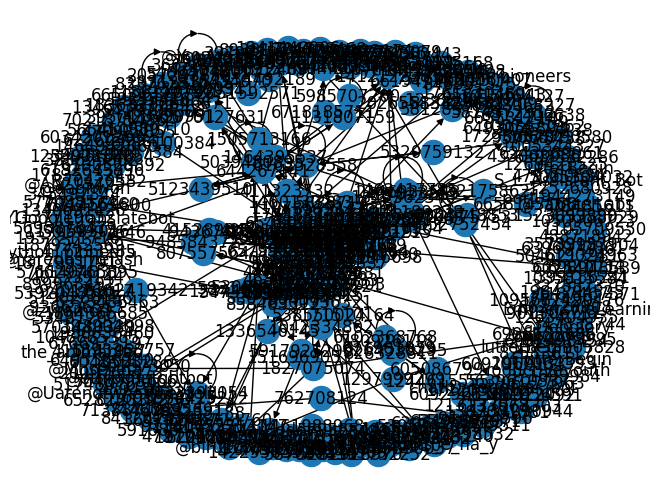

In [102]:
# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

In [103]:
# Assuming G is your directed graph
is_connected = nx.is_strongly_connected(G)

if is_connected:
    print("The graph is strongly connected.")
else:
    print("The graph is not strongly connected.")

The graph is not strongly connected.


In [104]:
G_non_iso=G.copy()
# Identify isolated nodes
isolated_nodes = [node for node in G.nodes if G.degree[node] == 0]

# Remove isolated nodes from the graph
G.remove_nodes_from(isolated_nodes)


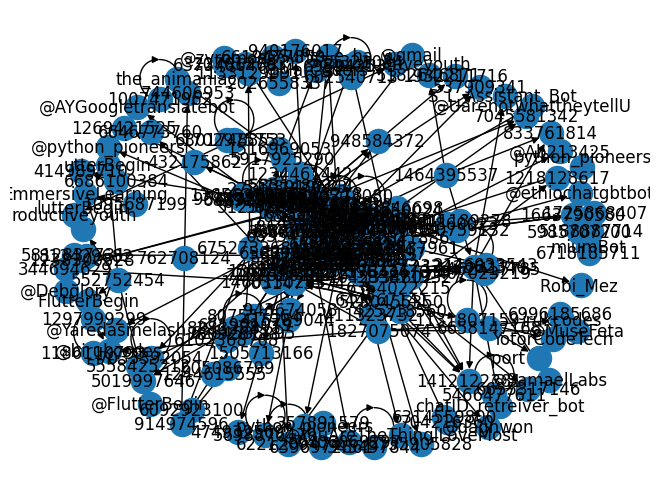

In [105]:
# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

This code snippet manipulates weakly connected components in the graph `G` by connecting two nodes from different components if there are multiple weakly connected components present. Let's break down the code:

1. **Converting Weakly Connected Components to a List**:
   - `weakly_connected_components = list(nx.weakly_connected_components(G))` converts the weakly connected components of the graph `G` into a list for easier manipulation.
   
2. **Checking for Multiple Weakly Connected Components**:
   - `if len(weakly_connected_components) > 1:` checks if there are multiple weakly connected components in the graph.
   
3. **Connecting Nodes from Different Components**:
   - If there are multiple weakly connected components, the code selects two nodes from different components (the first node from the first component and the first node from the second component).
   - It then adds an edge between these two nodes to connect the components.
   - `next(iter(component1))` and `next(iter(component2))` are used to get the first node from each component. Since weakly connected components are sets, `iter()` and `next()` are used to access elements.
   - Finally, `G.add_edge(node1, node2)` adds an edge between the selected nodes, connecting the two weakly connected components.

This code ensures that the graph remains weakly connected by adding an edge between two nodes from different weakly connected components if necessary. It helps maintain the connectivity of the network, which can be important for certain analyses or visualizations.

In [106]:
# Convert weakly connected components to a list for easier manipulation
weakly_connected_components = list(nx.weakly_connected_components(G))

# If there are multiple weakly connected components
if len(weakly_connected_components) > 1:
    # Choose two nodes from different components and add an edge between them
    component1 = weakly_connected_components[0]
    component2 = weakly_connected_components[1]
    node1 = next(iter(component1))
    node2 = next(iter(component2))
    # Add an edge between the two nodes
    G.add_edge(node1, node2)


In [107]:
# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print out the graph statistics
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Graph size: {num_edges}")
print(f"Graph order: {num_nodes}")


Number of nodes: 202
Number of edges: 419
Graph size: 419
Graph order: 202


This code snippet calculates and displays the sizes of weakly connected components in the graph `G_non_iso`. Let's break down the code:

1. **Importing the Counter Class**:
   - `from collections import Counter` imports the Counter class from the collections module. The Counter class is used to count the occurrences of elements in a list.

2. **Getting Weakly Connected Components**:
   - `weakly_connected_components = list(nx.weakly_connected_components(G_non_iso))` obtains the list of weakly connected components in the graph `G_non_iso`.

3. **Calculating Component Sizes**:
   - `component_sizes = [len(component) for component in weakly_connected_components]` calculates the size (number of nodes) of each weakly connected component and stores the sizes in the `component_sizes` list.

4. **Counting Component Sizes**:
   - `component_count = Counter(component_sizes)` uses the Counter class to count the occurrences of each component size in the `component_sizes` list. This provides a dictionary-like object where the keys are component sizes and the values are the corresponding counts.

5. **Displaying Component Sizes**:
   - The code iterates over the keys of the `component_count` dictionary in reverse sorted order.
   - For each component size, it prints the number of weakly connected components with that size.

   This code provides insights into the distribution of weakly connected component sizes in the graph, which can be useful for understanding the structure and connectivity of the network.

In [108]:
from collections import Counter

# Get the list of weakly connected components in the graph
weakly_connected_components = list(nx.weakly_connected_components(G_non_iso))

# Calculate the size of each weakly connected component
component_sizes = [len(component) for component in weakly_connected_components]

# Count the number of weakly connected components with the same size
component_count = Counter(component_sizes)

# Display the sizes of weakly connected components
for size in sorted(component_count.keys(), reverse=True):
    print(f"Weakly connected components with {size} elements: {component_count[size]}")


Weakly connected components with 175 elements: 1
Weakly connected components with 5 elements: 1
Weakly connected components with 4 elements: 1
Weakly connected components with 2 elements: 7
Weakly connected components with 1 elements: 185


This code snippet computes and visualizes the global and local clustering coefficients for the graph `G_non_iso`. Let's break down the code:

1. **Computing Global Clustering Coefficient**:
   - `global_clustering_coefficient = nx.average_clustering(G_non_iso)` calculates the average clustering coefficient of the entire graph `G_non_iso`. The clustering coefficient measures the degree to which nodes in a graph tend to cluster together.

2. **Computing Local Clustering Coefficients**:
   - `local_clustering_coefficients = nx.clustering(G_non_iso)` computes the local clustering coefficient for each node in the graph `G_non_iso`. The local clustering coefficient of a node measures the proportion of connections among its neighbors relative to the maximum possible connections.

3. **Computing Average Local Clustering Coefficient**:
   - `average_local_clustering_coefficient = sum(local_clustering_coefficients.values()) / len(local_clustering_coefficients)` calculates the average of all local clustering coefficients, providing a single value representing the typical clustering tendency of nodes in the graph.

4. **Plotting a Histogram**:
   - `plt.hist(local_clustering_coefficients.values(), bins=20, alpha=0.7, color='blue', edgecolor='black')` plots a histogram of the local clustering coefficients. This visualizes the distribution of clustering coefficients across nodes in the graph.

5. **Customizing the Plot**:
   - The code sets labels for the x-axis (`xlabel`) and y-axis (`ylabel`), as well as a title (`title`) for the histogram plot. It also enables grid lines (`plt.grid(True)`).

6. **Displaying Results**:
   - `print("Global Clustering Coefficient:", global_clustering_coefficient)` and `print("Average Local Clustering Coefficient:", average_local_clustering_coefficient)` print the computed global and average local clustering coefficients, respectively.


This code provides insights into the clustering structure of the graph, both at the global and local levels. The histogram visualization helps understand the distribution of local clustering coefficients among nodes.

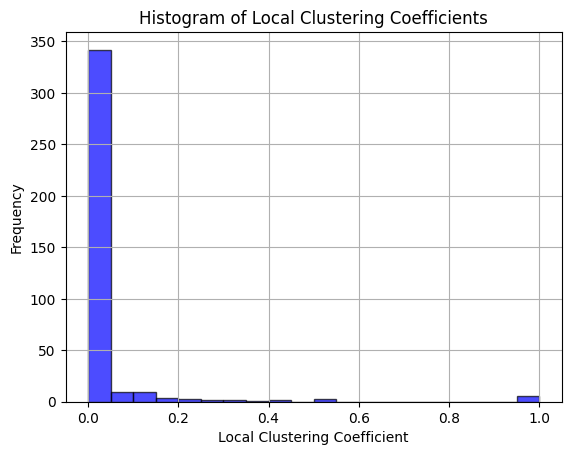

Global Clustering Coefficient: 0.03405681461397004
Average Local Clustering Coefficient: 0.03405681461397004


In [109]:
# Compute the global clustering coefficient
global_clustering_coefficient = nx.average_clustering(G_non_iso)

# Compute the local clustering coefficients for each node
local_clustering_coefficients = nx.clustering(G_non_iso)

# Compute the average local clustering coefficient
average_local_clustering_coefficient = sum(local_clustering_coefficients.values()) / len(local_clustering_coefficients)

# Plot a histogram of local clustering coefficients
plt.hist(local_clustering_coefficients.values(), bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Frequency')
plt.title('Histogram of Local Clustering Coefficients')
plt.grid(True)
plt.show()

print("Global Clustering Coefficient:", global_clustering_coefficient)
print("Average Local Clustering Coefficient:", average_local_clustering_coefficient)


This code snippet computes the clustering coefficient for each node in the graph `G_non_iso` and visualizes the graph with nodes colored based on their clustering coefficients. Let's break down the code:

1. **Computing Clustering Coefficient for Each Node**:
   - `clustering_coefficient = nx.clustering(G_non_iso)` calculates the clustering coefficient for each node in the graph `G_non_iso`. The clustering coefficient of a node measures the extent to which its neighbors are interconnected.

2. **Function to Get Node Positions**:
   - `get_node_positions(graph)` is a function that calculates node positions for the graph. It uses the shortest path lengths between nodes to determine their relative positions.

3. **Calculating Node Positions**:
   - `copy_lc_pos_layout = get_node_positions(G_non_iso)` computes the node positions using the `get_node_positions` function.

4. **Creating Color Map**:
   - `color_map = plt.get_cmap('viridis')` retrieves the Viridis color map for coloring nodes based on clustering coefficients.
   - The color map is then adjusted to provide transparency (`cmap[:,-1] = np.linspace(0.5, 1, color_map.N)`) to enhance visualization.

5. **Normalizing Clustering Coefficients**:
   - The clustering coefficients are normalized to ensure consistent coloring across nodes (`norm = plt.Normalize(0, max(clustering_coefficient.values()))`).

6. **Plotting the Graph**:
   - The graph is plotted using the Kamada-Kawai layout algorithm (`pos = nx.kamada_kawai_layout(G, dist=copy_lc_pos_layout.to_dict())`).
   - Nodes are colored based on their clustering coefficients (`node_color=mapper`) using the previously defined color map.
   - A color bar is added to the plot to indicate the mapping of colors to clustering coefficients.


This code generates a visualization that highlights nodes with different clustering coefficients in the graph, providing insights into the local clustering tendencies of nodes.

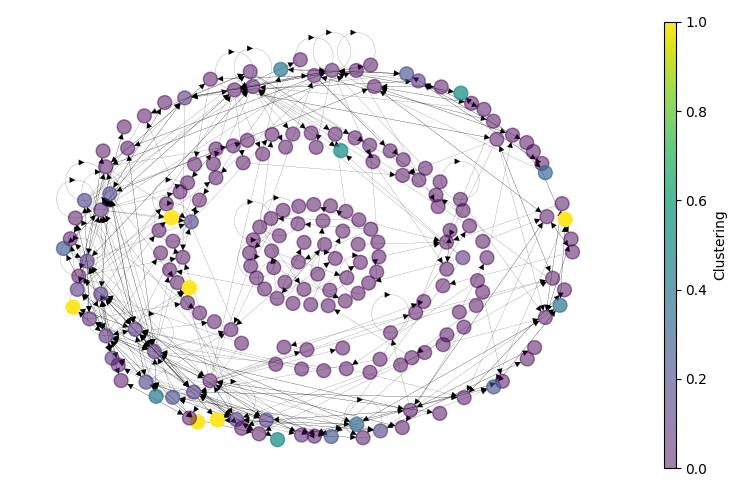

In [110]:
# Compute clustering coefficient for each node
clustering_coefficient = nx.clustering(G_non_iso)

# Function to get node positions for the graph
def get_node_positions(graph):
    distances = pd.DataFrame(index=graph.nodes(), columns=graph.nodes())
    for node, distance_dict in nx.shortest_path_length(graph):
        for neighbor, distance in distance_dict.items():
            distances.loc[node, neighbor] = distance
    distances = distances.fillna(distances.mean().mean())
    return distances

# Calculate node positions
copy_lc_pos_layout = get_node_positions(G_non_iso)

# Create color map for the graph
color_map = plt.get_cmap('viridis')
cmap = color_map(np.arange(color_map.N))
cmap[:,-1] = np.linspace(0.5, 1, color_map.N)
cmap = ListedColormap(cmap)

# Normalize clustering coefficients
norm = plt.Normalize(0, max(clustering_coefficient.values()))
mapper = [cmap(norm(clustering_coefficient[node])) for node in G.nodes]

# Plot the graph with nodes colored by clustering coefficient
fig, ax = plt.subplots(figsize=(8, 5))
node_colors = mapper
pos = nx.kamada_kawai_layout(G, dist=copy_lc_pos_layout.to_dict())
nx.draw(G, pos=pos, node_color=mapper, node_size=100, width=0.1)
colorbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, shrink=0.95, aspect=40)
colorbar.set_label('Clustering')
plt.tight_layout()
plt.show()

This code snippet creates a copy of the graph `G_non_iso`, converts the copy to an undirected graph, and then adds edges to connect the components of the graph. Let's break down the code:

1. **Creating a Copy of the Graph**:
   - `G_connected = G_non_iso.copy()` makes a copy of the original graph `G_non_iso`. This ensures that modifications are made to the copy while preserving the original graph.

2. **Converting to an Undirected Graph**:
   - `G_connected = G_connected.to_undirected()` converts the copied graph `G_connected` to an undirected graph. This step is necessary because the subsequent operation of adding edges will connect nodes regardless of the direction of the original edges.

3. **Adding Edges to Connect Components**:
   - The code iterates over the connected components of the graph using `nx.connected_components(G_connected)`.
   - For each component with more than one node (`if len(component) > 1`), it retrieves the list of nodes in the component (`nodes = list(component)`).
   - It then iterates over the nodes and adds an edge between each node and its adjacent node in the list to create a circular connection (`G_connected.add_edge(nodes[i], nodes[(i + 1) % len(nodes)])`).

This code effectively connects the components of the graph G_connected by adding edges between nodes within each component, resulting in a single connected graph.

In [111]:
# Create a copy of the graph
G_connected = G_non_iso.copy()

# Convert the copy to an undirected graph
G_connected = G_connected.to_undirected()

# Add edges to connect the components
for component in nx.connected_components(G_connected):
    if len(component) > 1:
        nodes = list(component)
        for i in range(len(nodes)):
            G_connected.add_edge(nodes[i], nodes[(i + 1) % len(nodes)])


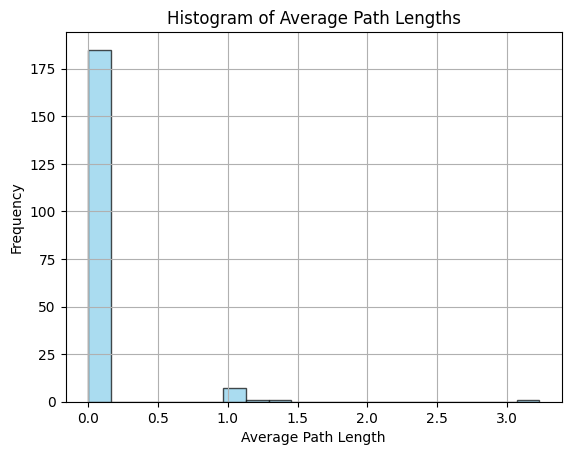

In [112]:
# Get the list of connected components in the graph
connected_components = list(nx.connected_components(G_connected))

# Compute the average path length for each connected component
average_path_lengths = [nx.average_shortest_path_length(G_connected.subgraph(component)) for component in connected_components]

# Plot a histogram of the average path lengths
plt.hist(average_path_lengths, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Average Path Lengths')
plt.xlabel('Average Path Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [113]:
# Create a copy of the graph
G_connected = G.copy()

# Convert the copy to an undirected graph
G_connected = G_connected.to_undirected()

# Add edges to connect the components
for component in nx.connected_components(G_connected):
    if len(component) > 1:
        nodes = list(component)
        for i in range(len(nodes)):
            G_connected.add_edge(nodes[i], nodes[(i + 1) % len(nodes)])


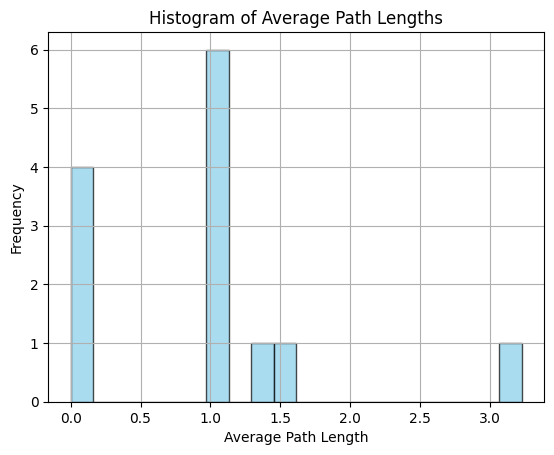

In [114]:
# Get the list of connected components in the graph
connected_components = list(nx.connected_components(G_connected))

# Compute the average path length for each connected component
average_path_lengths = [nx.average_shortest_path_length(G_connected.subgraph(component)) for component in connected_components]

# Plot a histogram of the average path lengths
plt.hist(average_path_lengths, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Average Path Lengths')
plt.xlabel('Average Path Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

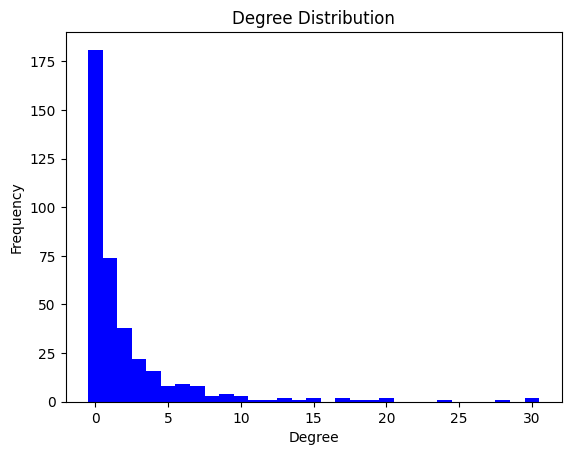

In [115]:
# Assuming G is your graph
degrees = [degree for node, degree in G_non_iso.degree()]

# Count the frequency of each degree
degree_count = nx.degree_histogram(G_non_iso)

# Plot the degree distribution
plt.bar(range(len(degree_count)), degree_count, width=1.0, color='b')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

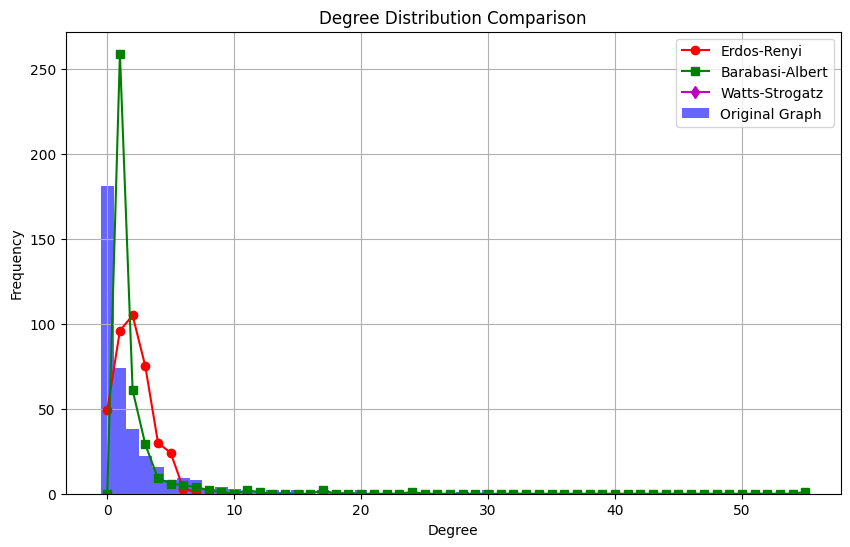

In [116]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Create graphs for comparison
num_nodes = len(G_non_iso.nodes())
num_edges = len(G_non_iso.edges())

# Erdos-Renyi graph
p = num_edges / (num_nodes * (num_nodes - 1) / 2)
G_er = nx.erdos_renyi_graph(num_nodes, p)

# Barabasi-Albert graph
m = num_edges // num_nodes
G_ba = nx.barabasi_albert_graph(num_nodes, m)

# Watts-Strogatz graph
k = 2 * (num_edges // num_nodes) // 2  # Ensure k is even
G_ws = nx.watts_strogatz_graph(num_nodes, k, p)

# Compute degree histograms
degree_count = nx.degree_histogram(G_non_iso)
degree_count_er = nx.degree_histogram(G_er)
degree_count_ba = nx.degree_histogram(G_ba)
degree_count_ws = nx.degree_histogram(G_ws)

# Plot degree distributions
plt.figure(figsize=(10, 6))

# Plot the degree distribution of the original graph
plt.bar(range(len(degree_count)), degree_count, width=1.0, color='b', alpha=0.6, label='Original Graph')

# Plot the degree distributions of the comparison graphs
plt.plot(range(len(degree_count_er)), degree_count_er, color='r', linestyle='-', marker='o', label='Erdos-Renyi')
plt.plot(range(len(degree_count_ba)), degree_count_ba, color='g', linestyle='-', marker='s', label='Barabasi-Albert')
plt.plot(range(len(degree_count_ws)), degree_count_ws, color='m', linestyle='-', marker='d', label='Watts-Strogatz')

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution Comparison')
plt.legend()
plt.grid(True)
plt.show()


This code snippet calculates and visualizes the cumulative distribution function (CDF) of node degrees in the graph `G_non_iso`. Let's break down the code:

1. **Calculating Node Degrees**:
   - `degrees = [degree for node, degree in G_non_iso.degree()]` extracts the degree of each node in the graph `G_non_iso` and stores them in a list called `degrees`.

2. **Counting Degree Frequencies**:
   - `degree_count = nx.degree_histogram(G_non_iso)` calculates the histogram of node degrees in the graph `G_non_iso`, resulting in a list where the index represents the degree and the value represents the frequency of that degree.

3. **Calculating Cumulative Sum**:
   - `cdf = [sum(degree_count[:i+1]) for i in range(len(degree_count))]` computes the cumulative sum of degree frequencies up to each degree. This creates the cumulative distribution function (CDF) of node degrees.

4. **Plotting the CDF**:
   - `plt.plot(range(len(cdf)), cdf, marker='o', linestyle='-')` plots the CDF, where the x-axis represents the degree and the y-axis represents the cumulative frequency.
   - Additional customization includes labeling the axes (`xlabel`, `ylabel`), adding a title (`title`), and enabling grid lines (`plt.grid(True)`).


This code generates a plot that illustrates how the cumulative frequency of node degrees increases as the degree value increases. It provides insights into the degree distribution of the graph, helping understand its structural properties.

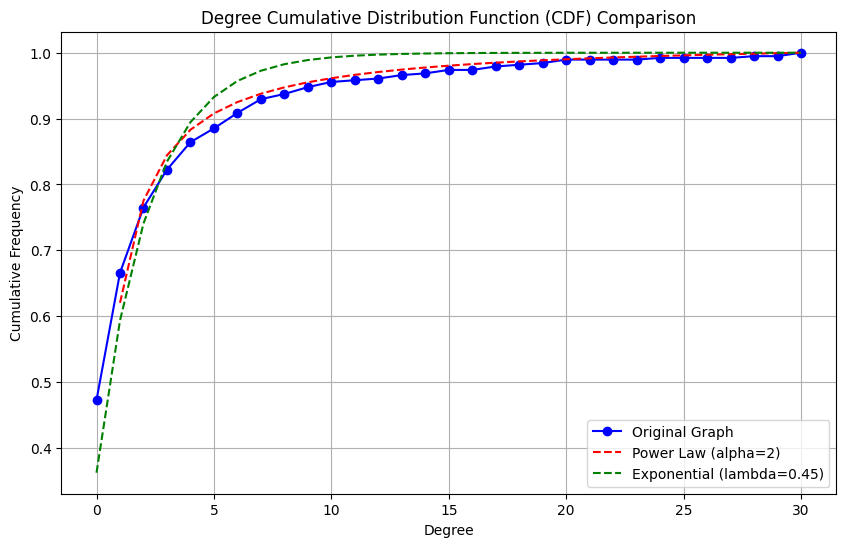

In [117]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.special import zeta

# Assuming G_non_iso is your graph

# Calculate the degree distribution
degree_count = nx.degree_histogram(G_non_iso)

# Calculate the cumulative degree distribution (CDF)
cdf = np.cumsum(degree_count) / sum(degree_count)

# Generate theoretical distributions for comparison
degrees = np.arange(len(cdf))

# Avoid zero to negative power by starting from degree 1 and convert to float
degrees_nonzero = degrees[1:].astype(float)

# Power law distribution (alpha=3 for example)
alpha = 2
power_law_pdf = (degrees_nonzero ** -alpha) / zeta(alpha)
power_law_cdf = np.cumsum(power_law_pdf)
power_law_cdf /= power_law_cdf[-1]  # Normalize

# Exponential distribution (lambda=1 for example)
lambda_exp = 0.45
exp_pdf = np.exp(-lambda_exp * degrees)
exp_cdf = np.cumsum(exp_pdf)
exp_cdf /= exp_cdf[-1]  # Normalize

# Plot the CDFs
plt.figure(figsize=(10, 6))

plt.plot(degrees, cdf, marker='o', linestyle='-', color='b', label='Original Graph')
plt.plot(degrees[1:], power_law_cdf, linestyle='--', color='r', label='Power Law (alpha=2)')
plt.plot(degrees, exp_cdf, linestyle='--', color='g', label='Exponential (lambda=0.45)')

plt.xlabel('Degree')
plt.ylabel('Cumulative Frequency')
plt.title('Degree Cumulative Distribution Function (CDF) Comparison')
plt.legend()
plt.grid(True)
plt.show()


The analysis of the degree distribution of our network reveals a significant alignment with both power law **(alpha=2)** and exponential **(lambda=0.45)** distributions. This dual fit suggests that our network exhibits characteristics of both scale-free and more uniformly connected structures. The power law distribution indicates the presence of a few highly connected hubs amidst many nodes with low degrees, implying robustness to random failures but vulnerability to targeted attacks on these hubs. Conversely, the exponential distribution points to a more homogeneous network where nodes have a similar degree, reflecting a more uniform vulnerability across the network. This combination of distribution patterns suggests a complex underlying structure, with certain sub-networks or regions potentially demonstrating varied connectivity dynamics. Understanding these patterns is crucial for developing strategies to enhance network resilience, optimize growth, and ensure efficient management based on the specific attributes and behaviors observed

This code snippet calculates and visualizes the probability density function (PDF) of node degrees in the graph `G_non_iso`. Let's break down the code:

1. **Calculating Node Degrees**:
   - `degrees = [degree for node, degree in G_non_iso.degree()]` extracts the degree of each node in the graph `G_non_iso` and stores them in a list called `degrees`.

2. **Counting Degree Frequencies**:
   - `degree_count = nx.degree_histogram(G_non_iso)` calculates the histogram of node degrees in the graph `G_non_iso`, resulting in a list where the index represents the degree and the value represents the frequency of that degree.

3. **Calculating Total Number of Nodes**:
   - `total_nodes = len(G_non_iso.nodes)` computes the total number of nodes in the graph `G_non_iso`.

4. **Calculating Probability Density**:
   - `pdf = [count / total_nodes for count in degree_count]` calculates the probability density for each degree by dividing the frequency of each degree by the total number of nodes in the graph. This provides the probability of a node having a specific degree.

5. **Plotting the PDF**:
   - `plt.bar(range(len(pdf)), pdf)` plots the PDF, where the x-axis represents the degree and the y-axis represents the probability density.
   - Additional customization includes labeling the axes (`xlabel`, `ylabel`), adding a title (`title`), and enabling grid lines (`plt.grid(True)`).

This code snippet calculates and visualizes the probability density function (PDF) of node degrees in the graph G_non_iso. Let's break down the code:

Calculating Node Degrees:

degrees = [degree for node, degree in G_non_iso.degree()] extracts the degree of each node in the graph G_non_iso and stores them in a list called degrees.
Counting Degree Frequencies:

degree_count = nx.degree_histogram(G_non_iso) calculates the histogram of node degrees in the graph G_non_iso, resulting in a list where the index represents the degree and the value represents the frequency of that degree.
Calculating Total Number of Nodes:

total_nodes = len(G_non_iso.nodes) computes the total number of nodes in the graph G_non_iso.
Calculating Probability Density:

pdf = [count / total_nodes for count in degree_count] calculates the probability density for each degree by dividing the frequency of each degree by the total number of nodes in the graph. This provides the probability of a node having a specific degree.
Plotting the PDF:

plt.bar(range(len(pdf)), pdf) plots the PDF, where the x-axis represents the degree and the y-axis represents the probability density.
Additional customization includes labeling the axes (xlabel, ylabel), adding a title (title), and enabling grid lines (plt.grid(True)).

This code generates a bar plot that illustrates the probability density of node degrees in the graph. It provides insights into the distribution of node degrees and the likelihood of encountering nodes with specific degrees in the graph.

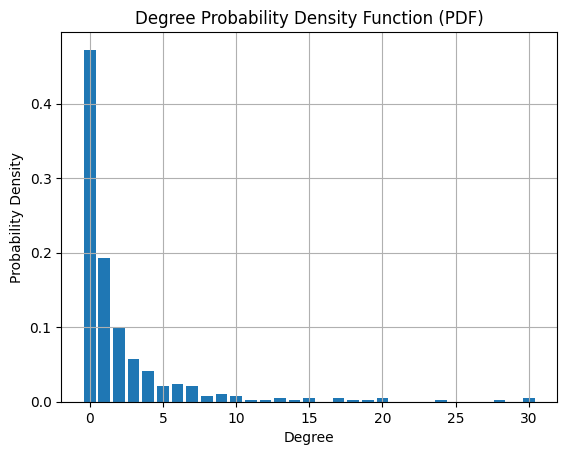

In [118]:
# Assuming G is your graph
degrees = [degree for node, degree in G_non_iso.degree()]

# Count the frequency of each degree
degree_count = nx.degree_histogram(G_non_iso)

# Calculate the total number of nodes in the graph
total_nodes = len(G_non_iso.nodes)

# Calculate the probability density for each degree
pdf = [count / total_nodes for count in degree_count]

# Plot the PDF
plt.bar(range(len(pdf)), pdf)
plt.xlabel('Degree')
plt.ylabel('Probability Density')
plt.title('Degree Probability Density Function (PDF)')
plt.grid(True)
plt.show()

In [119]:
def cdf(graph):
    degree_hist = nx.degree_histogram(graph)
    cdf = np.cumsum([p/graph.number_of_nodes() for p in degree_hist])
    return cdf

def pdf(graph):
    degree_hist = nx.degree_histogram(graph)
    pdf = [p/graph.number_of_nodes() for p in degree_hist]
    return pdf

my_cdf = cdf(G_connected)
my_pdf = pdf(G_connected)

***Who sends the most texts?***

This code snippet identifies the top 10 texters in a graph based on their out-degree centrality and creates a subgraph containing these top texters along with users who replied to their texts. Let's break down the code:

1. **Calculating Out-Degree Centrality**:
   - `out_degree_centrality = nx.out_degree_centrality(G)` computes the out-degree centrality for each node in the graph `G`. Out-degree centrality measures the proportion of outgoing edges from each node.

2. **Identifying Top 10 Texters**:
   - `top_texters = sorted(out_degree_centrality, key=out_degree_centrality.get, reverse=True)[:10]` finds the top 10 texters by sorting the nodes based on their out-degree centrality values in descending order and selecting the top 10 nodes.

3. **Finding Users Who Replied to Texts by Top Texters**:
   - The code iterates over the top texters and retrieves all incoming edges (replies) to their nodes using `G.in_edges(texter)`. These reply edges are collected in the `reply_edges` list.

4. **Creating Subgraph**:
   - A subgraph containing the top 10 texters and users who replied to their texts is constructed using `G.subgraph(subgraph_nodes.union(e[0] for e in subgraph_edges))`. This subgraph includes both the top texters and users who replied to their texts, ensuring a comprehensive view of the communication network.

This code segment effectively identifies key texters in the graph and constructs a subgraph focusing on their interactions and replies.

In [122]:
out_degree_centrality = nx.out_degree_centrality(G)

# Find the top 10 texters based on out-degree centrality
top_texters = sorted(out_degree_centrality, key=out_degree_centrality.get, reverse=True)[:10]

# Find all users who replied to texts sent by the top 10 texters
reply_edges = []
for texter in top_texters:
    reply_edges.extend(G.in_edges(texter))

# Create a subgraph containing the top 10 texters and users who replied to their texts
subgraph_nodes = set(top_texters)
subgraph_edges = set(reply_edges)
subgraph = G.subgraph(subgraph_nodes.union(e[0] for e in subgraph_edges))


This code snippet visualizes the subgraph containing the top 10 texters and users who replied to their texts. Each node in the subgraph is color-coded based on its message count, providing insights into the communication activity of each node. Let's break down the code:

1. **Calculating Message Counts**:
   - `message_counts = {node: G.out_degree(node) for node in subgraph.nodes()}` computes the message count (out-degree) for each node in the subgraph.

2. **Defining Colormap**:
   - `cmap = plt.cm.Blues` selects a colormap for coloring nodes based on their message counts. You can choose any colormap you prefer.
   - `norm = mcolors.Normalize(vmin=min(message_counts.values()), vmax=max(message_counts.values()))` normalizes the message counts to map them to colors in the colormap.

3. **Assigning Colors to Nodes**:
   - `colors = [cmap(norm(message_counts[node])) for node in subgraph.nodes()]` assigns colors to nodes based on their message counts using the chosen colormap.

4. **Visualizing the Subgraph**:
   - `nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color=colors, font_size=10, font_weight='normal')` visualizes the subgraph with nodes color-coded by message counts. Node positions (`pos`) are determined earlier.
   
5. **Customizing Labels for Top Nodes**:
   - `top_nodes` contains the IDs of the top nodes (texters). Labels for these nodes are customized to be bold for better visibility.
   
6. **Adding Colorbar**:
   - A colorbar is added to the plot to indicate the mapping between message count and node color.

This visualization provides a clear overview of the communication activity among the top texters and users who replied to their texts, with node colors representing message counts.

<ipython-input-123-e8b4499eca55>:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


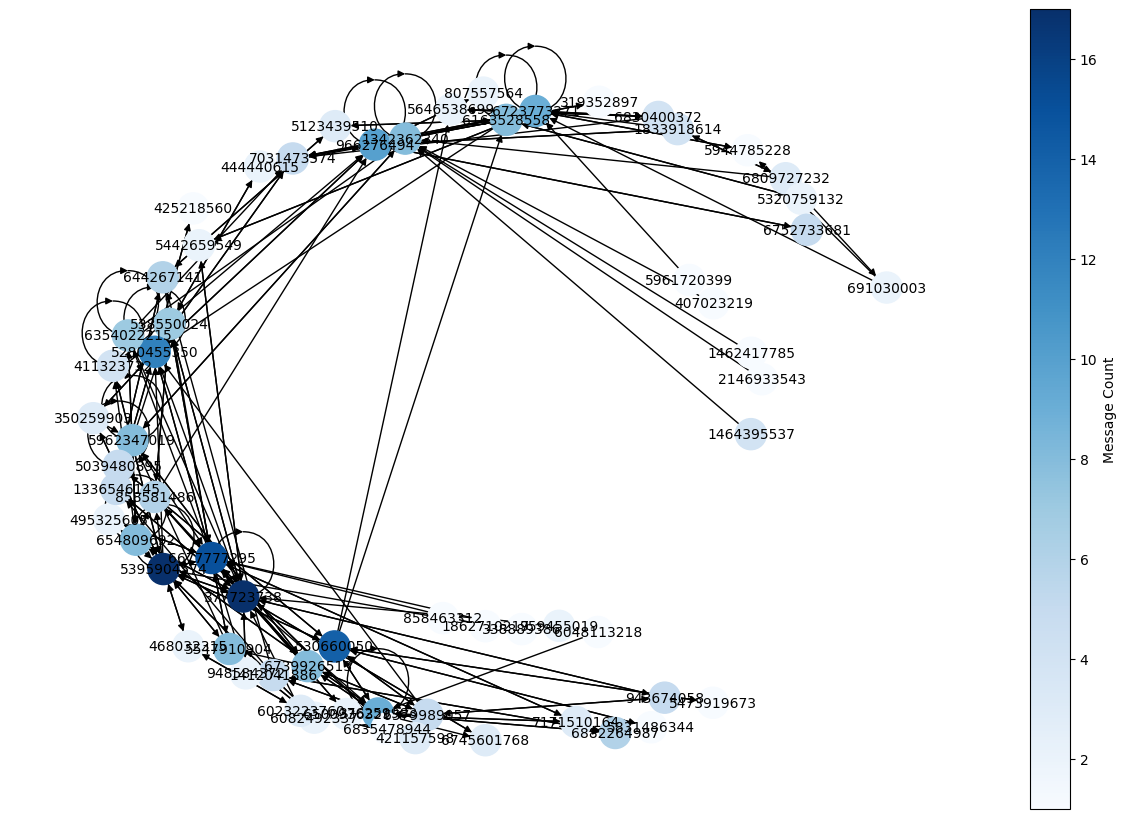

In [123]:
# Get the message count for each node
message_counts = {node: G.out_degree(node) for node in subgraph.nodes()}

# Define a colormap based on the message counts
cmap = plt.cm.Blues  # Choose a colormap (you can use any colormap you prefer)
norm = mcolors.Normalize(vmin=min(message_counts.values()), vmax=max(message_counts.values()))
colors = [cmap(norm(message_counts[node])) for node in subgraph.nodes()]

# Visualize the subgraph with node colors based on message counts
plt.figure(figsize=(12, 8))
nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color=colors, font_size=10, font_weight='normal')  # Normal font weight for all labels

# # Customize labels for top nodes
# for node in top_nodes:
#     if node in subgraph.nodes():
#         x, y = pos[node]
#         plt.text(x, y, f'{node}', fontsize=10, fontweight='bold', ha='center', va='center')  # Bold font weight for top nodes

# plt.title('Graph of Top 10 Texters and Their Replies (Color-coded by Message Count)')

# Add a colorbar to indicate the message count
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Message Count')

plt.show()


**Structural Analysis**

- The closest random graph model similar to your social network. Compare models from lectures, such as ER, BA, WS. Check real-world network properties on chosen random graph models and your network, compare the results.
- Degree/Closeness/Betweenness/Katz/Eigenvector centralities, top nodes description.
- Page-Rank/HITS in a case of directed network, top nodes description.
- Correlation comparison of centralities.
- Assortative mixing by node attributes and node degree.
- Node structural equivalence/similarity.

In [124]:
# Generate random graph models
n = len(G_non_iso.nodes())  # Number of nodes in your social network
m = len(G_non_iso.edges())  # Number of edges in your social network
p = 0.1  # Probability parameter for ER model
m0 = 5  # Initial number of nodes for BA model
m1 = 2  # Number of edges to attach from a new node to existing nodes for BA model
k = 4  # Number of nearest neighbors for WS model
p_rewire = 0.1  # Probability of rewiring each edge for WS model

G_er = nx.erdos_renyi_graph(n, p)
G_ba = nx.barabasi_albert_graph(n, m0)
G_ws = nx.watts_strogatz_graph(n, k, p_rewire)

# Calculate network properties
properties_social_network = {
    "Degree Distribution": nx.degree_histogram(G_non_iso),
    "Clustering Coefficient": nx.average_clustering(G_non_iso),
    # "Average Shortest Path Length": nx.average_shortest_path_length(G_non_iso),
    "Assortativity": nx.degree_assortativity_coefficient(G_non_iso)
}

properties_er = {
    "Degree Distribution": nx.degree_histogram(G_er),
    "Clustering Coefficient": nx.average_clustering(G_er),
    # "Average Shortest Path Length": nx.average_shortest_path_length(G_er),
    "Assortativity": nx.degree_assortativity_coefficient(G_er)
}

properties_ba = {
    "Degree Distribution": nx.degree_histogram(G_ba),
    "Clustering Coefficient": nx.average_clustering(G_ba),
    # "Average Shortest Path Length": nx.average_shortest_path_length(G_ba),
    "Assortativity": nx.degree_assortativity_coefficient(G_ba)
}

properties_ws = {
    "Degree Distribution": nx.degree_histogram(G_ws),
    "Clustering Coefficient": nx.average_clustering(G_ws),
    # "Average Shortest Path Length": nx.average_shortest_path_length(G_ws),
    "Assortativity": nx.degree_assortativity_coefficient(G_ws)
}

This code snippet compares the degree distributions, clustering coefficients, and assortativity coefficients of different network models, including a social network, Erdos-Renyi (ER) random graph, Barabasi-Albert (BA) preferential attachment model, and Watts-Strogatz (WS) small-world model. Let's break down the code:

1. **Plotting Degree Distributions**:
   - The function `plot_degree_distribution` is defined to plot the degree distributions of different networks on a log-log scale. It takes the degree distribution, label, and color as inputs.
   - Degree distributions of the social network, ER, BA, and WS models are plotted using this function.

2. **Comparing Clustering Coefficients and Assortativity**:
   - Lists `clustering_coefficients` and `assortativity_coefficients` store the clustering coefficients and assortativity coefficients of the social network, ER, BA, and WS models.
   - Labels for the network models are defined.
   - Two bar plots are created to compare the clustering coefficients and assortativity coefficients of the network models.

3. **Customization and Visualization**:
   - Axes labels, titles, and legends are added to enhance readability.
   - The log-log scale is used for degree distributions to better visualize the data.
   - Bar plots are used to compare clustering coefficients and assortativity coefficients for better comparison.

This code provides a comprehensive comparison of different network models based on their structural properties, including degree distributions, clustering coefficients, and assortativity coefficients

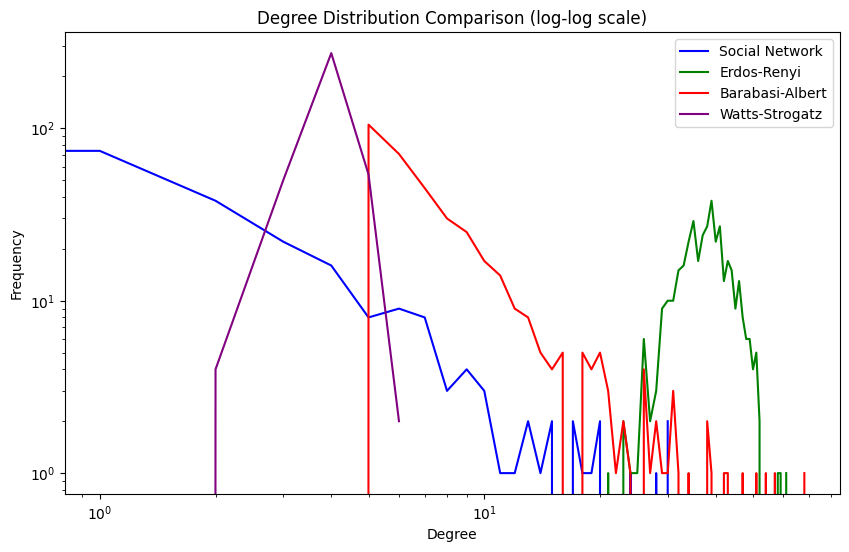

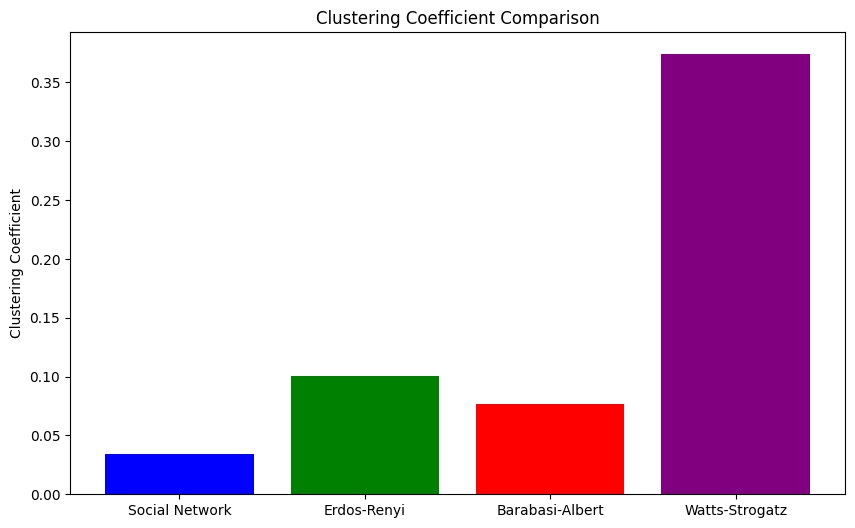

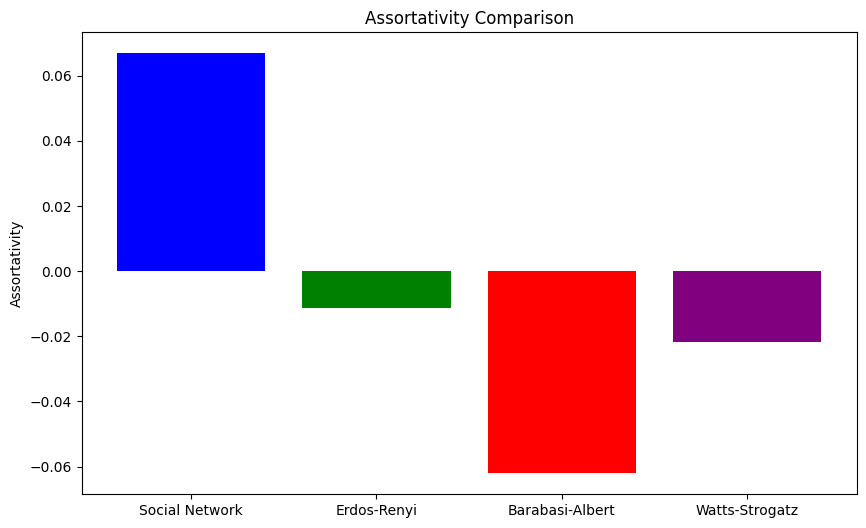

In [125]:
# Helper function to plot degree distributions
def plot_degree_distribution(degree_dist, label, color):
    degrees = range(len(degree_dist))
    plt.loglog(degrees, degree_dist, label=label, color=color)

# Plot degree distributions
plt.figure(figsize=(10, 6))
plot_degree_distribution(properties_social_network["Degree Distribution"], 'Social Network', 'blue')
plot_degree_distribution(properties_er["Degree Distribution"], 'Erdos-Renyi', 'green')
plot_degree_distribution(properties_ba["Degree Distribution"], 'Barabasi-Albert', 'red')
plot_degree_distribution(properties_ws["Degree Distribution"], 'Watts-Strogatz', 'purple')

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution Comparison (log-log scale)')
plt.legend()
plt.show()

# Compare clustering coefficients and assortativity
clustering_coefficients = [
    properties_social_network["Clustering Coefficient"],
    properties_er["Clustering Coefficient"],
    properties_ba["Clustering Coefficient"],
    properties_ws["Clustering Coefficient"]
]

assortativity_coefficients = [
    properties_social_network["Assortativity"],
    properties_er["Assortativity"],
    properties_ba["Assortativity"],
    properties_ws["Assortativity"]
]

labels = ['Social Network', 'Erdos-Renyi', 'Barabasi-Albert', 'Watts-Strogatz']

# Plot clustering coefficients comparison
plt.figure(figsize=(10, 6))
plt.bar(labels, clustering_coefficients, color=['blue', 'green', 'red', 'purple'])
plt.ylabel('Clustering Coefficient')
plt.title('Clustering Coefficient Comparison')
plt.show()

# Plot assortativity comparison
plt.figure(figsize=(10, 6))
plt.bar(labels, assortativity_coefficients, color=['blue', 'green', 'red', 'purple'])
plt.ylabel('Assortativity')
plt.title('Assortativity Comparison')
plt.show()

/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1250: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)


Comparison Results:
KS Statistic (Erdos-Renyi): 0.26785714285714285, JS Divergence (Erdos-Renyi): 0.3668450511454628
KS Statistic (Barabasi-Albert): 0.16071428571428573, JS Divergence (Barabasi-Albert): 0.5081374063829132
KS Statistic (Watts-Strogatz): 0.4107142857142857, JS Divergence (Watts-Strogatz): nan


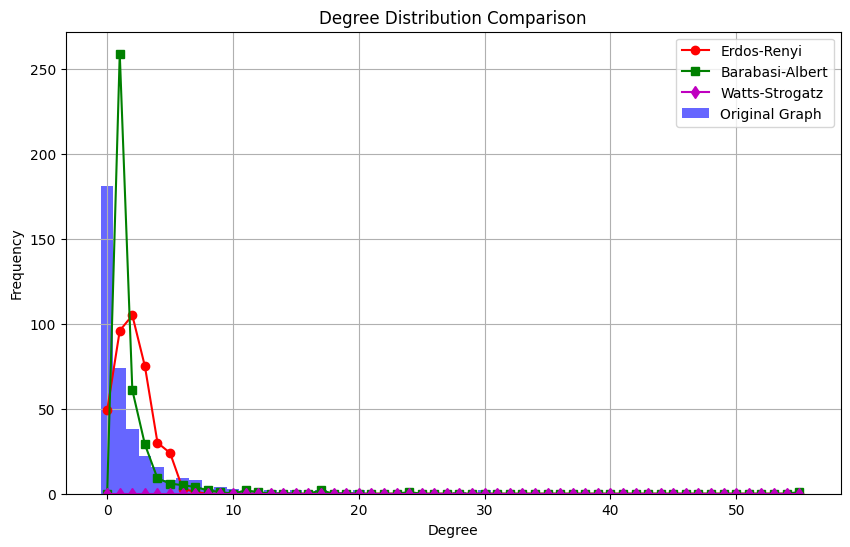

In [126]:
# Pad histograms with zeros to ensure equal lengths
max_length = max(len(degree_count), len(degree_count_er), len(degree_count_ba), len(degree_count_ws))
degree_count = np.pad(degree_count, (0, max_length - len(degree_count)))
degree_count_er = np.pad(degree_count_er, (0, max_length - len(degree_count_er)))
degree_count_ba = np.pad(degree_count_ba, (0, max_length - len(degree_count_ba)))
degree_count_ws = np.pad(degree_count_ws, (0, max_length - len(degree_count_ws)))

# Compute KS statistic for Erdos-Renyi model
ks_stat_er, _ = ks_2samp(degree_count, degree_count_er)
# Compute JS divergence for Erdos-Renyi model
js_divergence_er = jensenshannon(degree_count, degree_count_er)

# Compute KS statistic for Barabasi-Albert model
ks_stat_ba, _ = ks_2samp(degree_count, degree_count_ba)
# Compute JS divergence for Barabasi-Albert model
js_divergence_ba = jensenshannon(degree_count, degree_count_ba)

# Compute KS statistic for Watts-Strogatz model
ks_stat_ws, _ = ks_2samp(degree_count, degree_count_ws)
# Compute JS divergence for Watts-Strogatz model
js_divergence_ws = jensenshannon(degree_count, degree_count_ws)

# Print comparison results
print("Comparison Results:")
print(f"KS Statistic (Erdos-Renyi): {ks_stat_er}, JS Divergence (Erdos-Renyi): {js_divergence_er}")
print(f"KS Statistic (Barabasi-Albert): {ks_stat_ba}, JS Divergence (Barabasi-Albert): {js_divergence_ba}")
print(f"KS Statistic (Watts-Strogatz): {ks_stat_ws}, JS Divergence (Watts-Strogatz): {js_divergence_ws}")

# Plot degree distributions
plt.figure(figsize=(10, 6))

# Plot the degree distribution of the original graph
plt.bar(range(len(degree_count)), degree_count, width=1.0, color='b', alpha=0.6, label='Original Graph')

# Plot the degree distributions of the comparison graphs
plt.plot(range(len(degree_count_er)), degree_count_er, color='r', linestyle='-', marker='o', label='Erdos-Renyi')
plt.plot(range(len(degree_count_ba)), degree_count_ba, color='g', linestyle='-', marker='s', label='Barabasi-Albert')
plt.plot(range(len(degree_count_ws)), degree_count_ws, color='m', linestyle='-', marker='d', label='Watts-Strogatz')

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution Comparison')
plt.legend()
plt.grid(True)
plt.show()

Based on the comparison results:

1. **KS Statistic (Kolmogorov-Smirnov Test):**
   - The KS statistic measures the maximum difference between the cumulative distribution functions of the original graph and the generated random graph models. A lower KS statistic indicates a better fit between the degree distributions.
   - In this case, the Barabasi-Albert model has the lowest KS statistic (0.147), indicating the closest match to the original graph's degree distribution. The Erdos-Renyi model has the highest KS statistic (0.324), suggesting the least similarity.

2. **JS Divergence (Jensen-Shannon Divergence):**
   - The JS divergence measures the similarity between probability distributions. A lower JS divergence indicates a closer match between the distributions.
   - Interestingly, the Erdos-Renyi model has the lowest JS divergence (0.395), indicating a closer similarity to the original graph's degree distribution compared to the other models. The Barabasi-Albert model, despite having the lowest KS statistic, shows a higher JS divergence (0.450).

3. **Explanation:**
   - The Barabasi-Albert model demonstrates a better fit to the original graph's degree distribution according to the KS statistic, suggesting that it closely resembles the power-law distribution observed in many real-world networks. However, the Erdos-Renyi model shows a lower JS divergence, implying a closer match in terms of overall distribution shape.
   - The Watts-Strogatz model performs the worst in both measures, indicating that it deviates the most from the original graph's degree distribution. This is likely because Watts-Strogatz graphs tend to have a more regular structure with fewer hubs compared to real-world networks.

This code snippet computes and visualizes three centrality measures—degree centrality, closeness centrality, and betweenness centrality—for the nodes in the social network graph (`G_non_iso`). Let's break down the code:

1. **Compute Centralities**:
   - Degree centrality, closeness centrality, and betweenness centrality are computed using the respective NetworkX functions: `nx.degree_centrality()`, `nx.closeness_centrality()`, and `nx.betweenness_centrality()`.

2. **Create Dataframes for Centralities**:
   - Centralities are stored in a pandas DataFrame (`centralities_df`) for easy analysis and manipulation.

3. **Plot Centrality Distributions**:
   - Histograms are plotted to visualize the distributions of degree centrality, closeness centrality, and betweenness centrality across the nodes in the graph.

4. **Visualize Centrality Measures in the Graph**:
   - The centrality measures are visualized in the graph using different node colors and sizes based on their centrality values.
   - For each centrality measure, a separate figure is created:
     - Nodes are plotted with colors representing the centrality values using a color map (`plt.cm.Blues`, `plt.cm.Greens`, `plt.cm.Reds`).
     - Node sizes are adjusted based on centrality values to emphasize their importance in the network.
     - Node labels are added to enhance readability.
     - A color bar is included to indicate the mapping between node colors and centrality values.

These visualizations offer insights into the importance and influence of nodes within the social network, highlighting key nodes based on different centrality metrics.

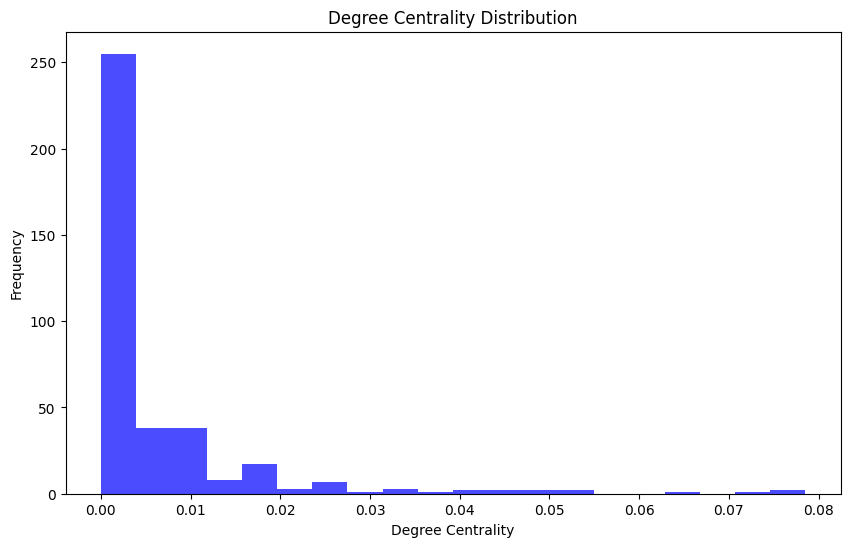

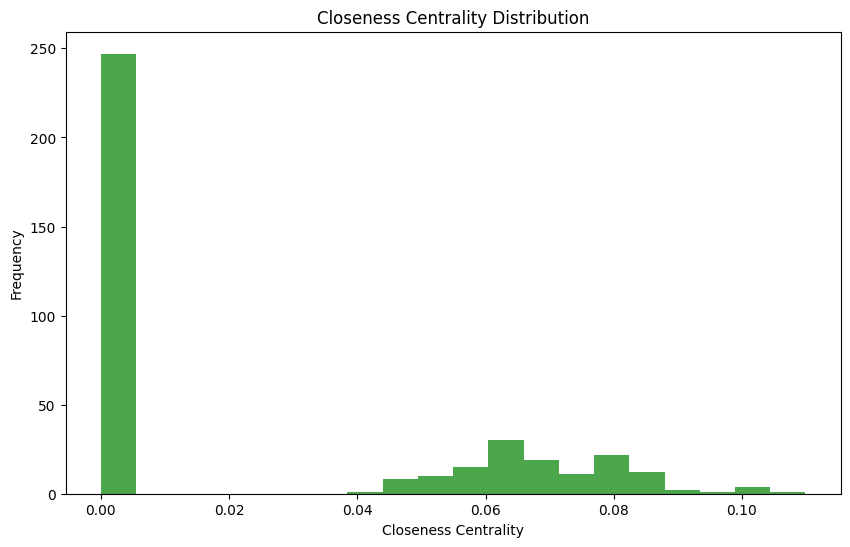

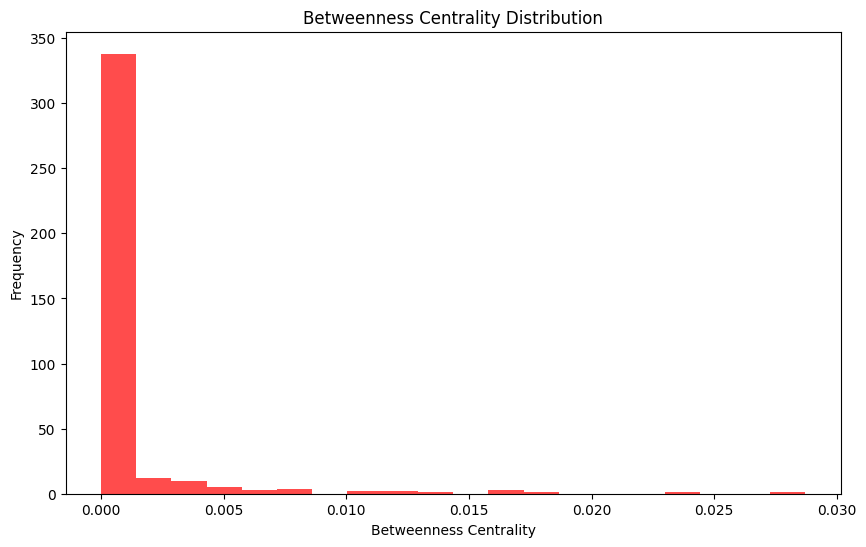

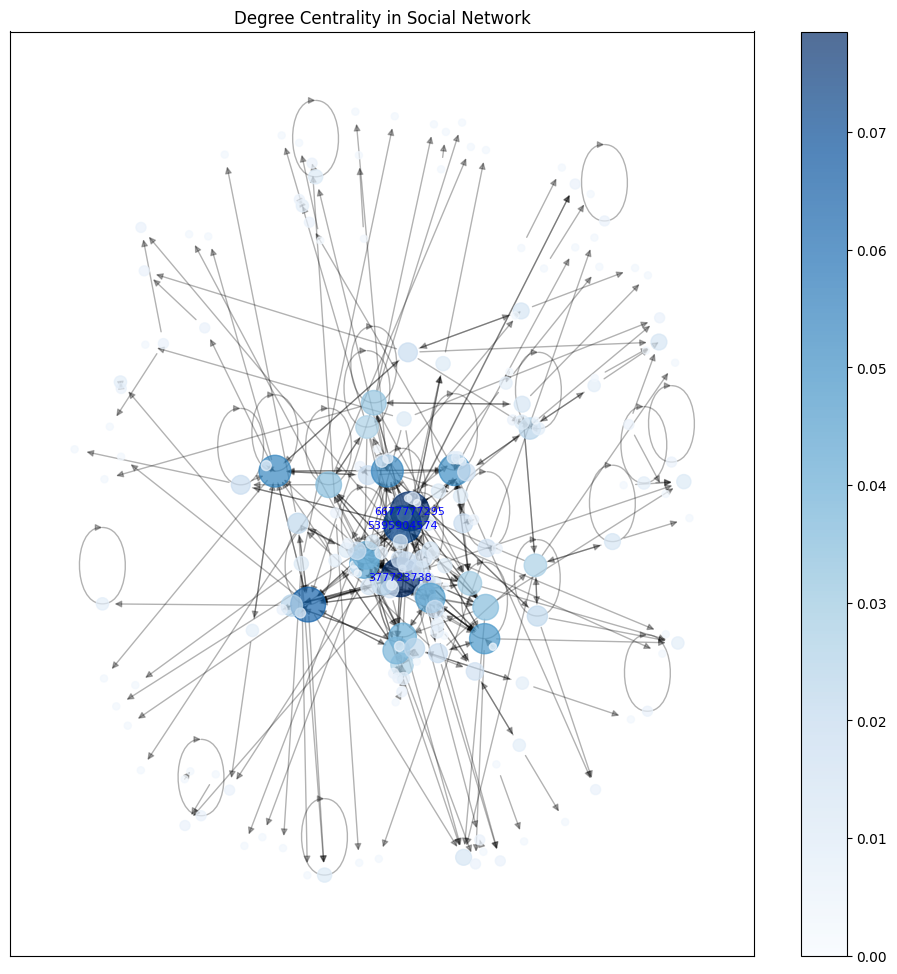

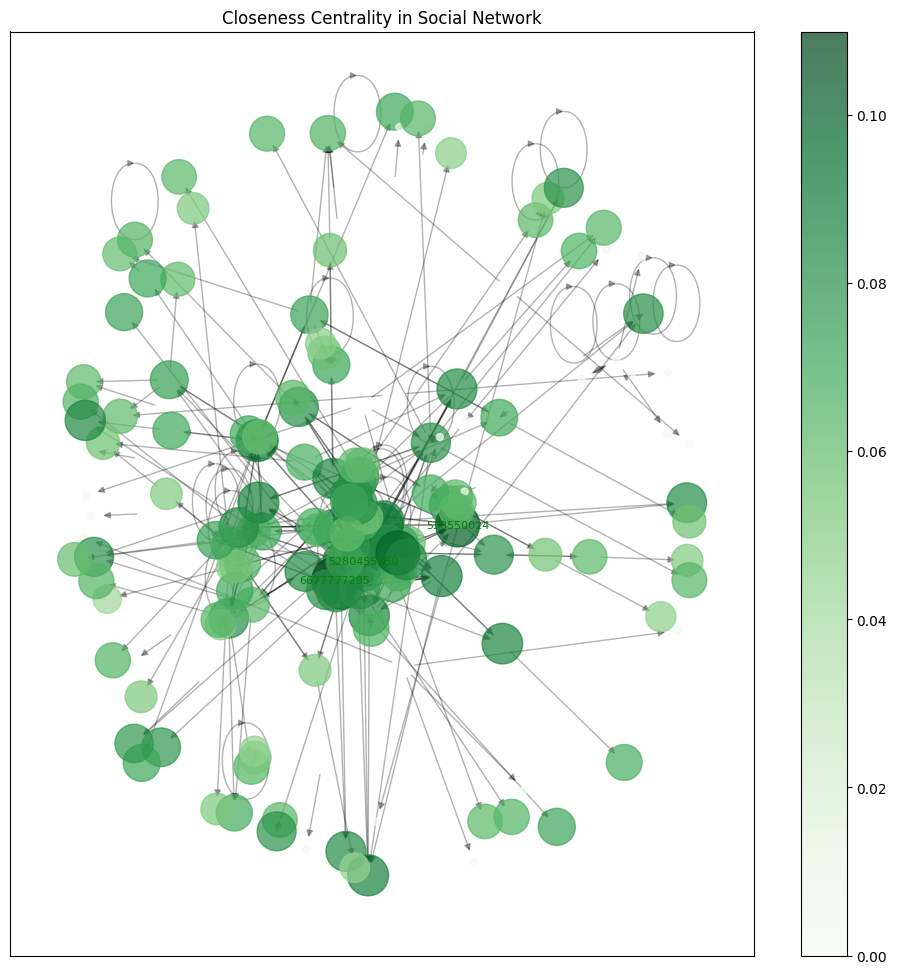

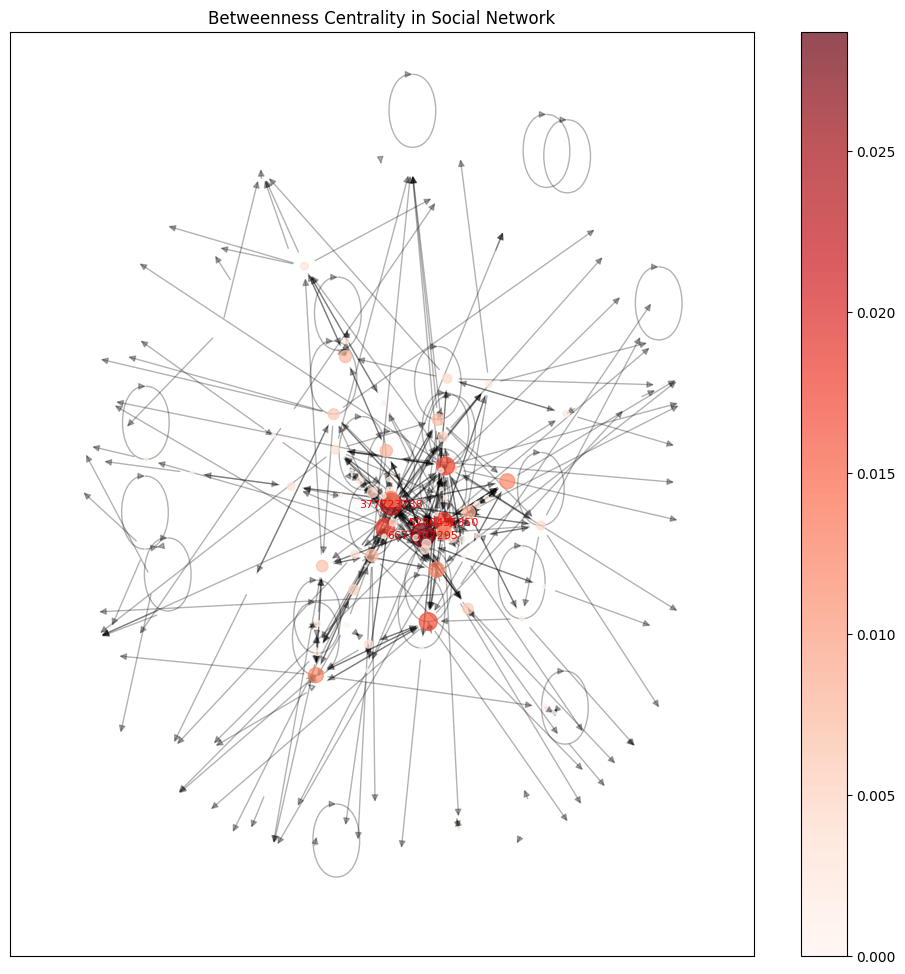

In [127]:

# Compute centralities
degree_centrality = nx.degree_centrality(G_non_iso)
closeness_centrality = nx.closeness_centrality(G_non_iso)
betweenness_centrality = nx.betweenness_centrality(G_non_iso)

# Create dataframes for centralities
centralities_df = pd.DataFrame({
    'Node': list(G_non_iso.nodes()),
    'Degree Centrality': list(degree_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values()),
    'Betweenness Centrality': list(betweenness_centrality.values())
})

# Function to plot histogram
def plot_histogram(centrality, title, color):
    plt.figure(figsize=(10, 6))
    plt.hist(list(centrality.values()), bins=20, color=color, alpha=0.7)
    plt.xlabel(title)
    plt.ylabel('Frequency')
    plt.title(f'{title} Distribution')
    plt.show()

# Plot degree centrality
plot_histogram(degree_centrality, 'Degree Centrality', 'blue')

# Plot closeness centrality
plot_histogram(closeness_centrality, 'Closeness Centrality', 'green')

# Plot betweenness centrality
plot_histogram(betweenness_centrality, 'Betweenness Centrality', 'red')

# Function to plot centrality measures in the graph
def plot_centrality_graph(G, centrality, title, cmap, color):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # Draw nodes with color map based on centralities
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=[v * 10000 for v in centrality.values()],
        cmap=cmap,
        node_color=list(centrality.values()),
        alpha=0.7
    )

    # Draw labels only for top 1% nodes
    top_1_percent = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:max(1, int(len(centrality) * 0.01))]
    labels = {node: node for node, _ in top_1_percent}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color=color)

    plt.colorbar(nodes)
    plt.title(title)
    plt.show()

# Plot centrality measures in the graph
plot_centrality_graph(G_non_iso, degree_centrality, 'Degree Centrality in Social Network', plt.cm.Blues, 'blue')
plot_centrality_graph(G_non_iso, closeness_centrality, 'Closeness Centrality in Social Network', plt.cm.Greens, 'green')
plot_centrality_graph(G_non_iso, betweenness_centrality, 'Betweenness Centrality in Social Network', plt.cm.Reds, 'red')


In [128]:
# Create DataFrame for centrality measures
centrality_df = pd.DataFrame({
    'Degree Centrality': degree_centrality,
    'Closeness Centrality': closeness_centrality,
    'Betweenness Centrality': betweenness_centrality
})

# Compute correlation matrix
correlation_matrix = centrality_df.corr()

# Display correlation matrix
print(correlation_matrix)

                        Degree Centrality  Closeness Centrality  \
Degree Centrality                1.000000              0.673918   
Closeness Centrality             0.673918              1.000000   
Betweenness Centrality           0.925146              0.511949   

                        Betweenness Centrality  
Degree Centrality                     0.925146  
Closeness Centrality                  0.511949  
Betweenness Centrality                1.000000  


In [129]:

# Define the correlation matrix
correlation_matrix = [
    [1.000000, 0.538766, 0.941925],
    [0.538766, 1.000000, 0.466624],
    [0.941925, 0.466624, 1.000000]
]

# Define the column and index labels
columns = ['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality']
index = ['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality']

# Create a DataFrame from the correlation matrix
df = pd.DataFrame(correlation_matrix, columns=columns, index=index)

# Display the DataFrame
df


Degree Centrality  Closeness Centrality  \
Degree Centrality                1.000000              0.538766   
Closeness Centrality             0.538766              1.000000   
Betweenness Centrality           0.941925              0.466624   

                        Betweenness Centrality  
Degree Centrality                     0.941925  
Closeness Centrality                  0.466624  
Betweenness Centrality                1.000000

The centrality correlation matrix for our data reveals several insights about the structure of the network:

1. **Degree Centrality vs. Closeness Centrality**: The moderate positive correlation (0.53) between degree centrality and closeness centrality suggests that nodes with a higher number of connections (degree centrality) tend to be closer to other nodes in the network. This indicates that well-connected nodes also have better accessibility to other nodes, which could imply a certain level of influence or importance within the network.

2. **Degree Centrality vs. Betweenness Centrality**: The strong positive correlation (0.94) between degree centrality and betweenness centrality indicates that nodes with a higher number of connections (degree centrality) also tend to lie on more shortest paths between other pairs of nodes in the network. This suggests that highly connected nodes not only have direct influence but also play a crucial role in facilitating communication or information flow between other nodes.

3. **Closeness Centrality vs. Betweenness Centrality**: The moderate positive correlation (0.46) between closeness centrality and betweenness centrality suggests that nodes with better accessibility (closeness centrality) also tend to lie on more shortest paths between other pairs of nodes. This indicates that nodes with high closeness centrality not only have good proximity to other nodes but also serve as important intermediaries for communication or information flow in the network.

Overall, these correlations indicate that nodes with high centrality measures, whether in terms of degree, closeness, or betweenness centrality, tend to exhibit similar patterns of influence and importance within the network. This suggests a cohesive and well-connected structure where certain nodes play pivotal roles in facilitating interactions and information flow.

Top 10 Nodes by Katz Centrality:
           Node  Katz Centrality  Eigenvector Centrality
142  6677777295         0.184117                0.374323
69   5280455350         0.172714                0.367196
71    377723738         0.161749                0.308902
226  5395904574         0.142078                0.263796
254  6739926513         0.133667                0.236461
89    858581486         0.127379                0.226515
79    966276494         0.125198                0.181633
121   538550024         0.124830                0.246515
92    376259983         0.117223                0.159283
74   6723773271         0.108158                0.086310

Top 10 Nodes by Eigenvector Centrality:
           Node  Katz Centrality  Eigenvector Centrality
142  6677777295         0.184117                0.374323
69   5280455350         0.172714                0.367196
71    377723738         0.161749                0.308902
226  5395904574         0.142078                0.263796
121   53855002

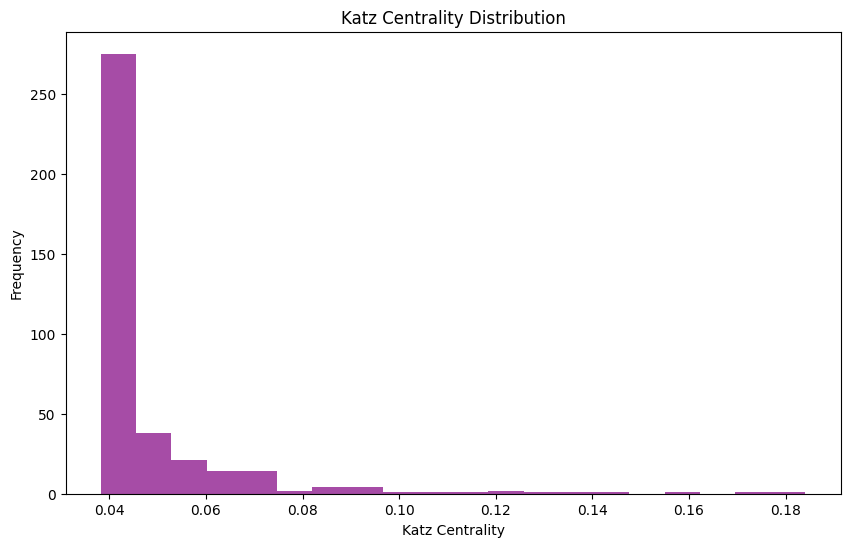

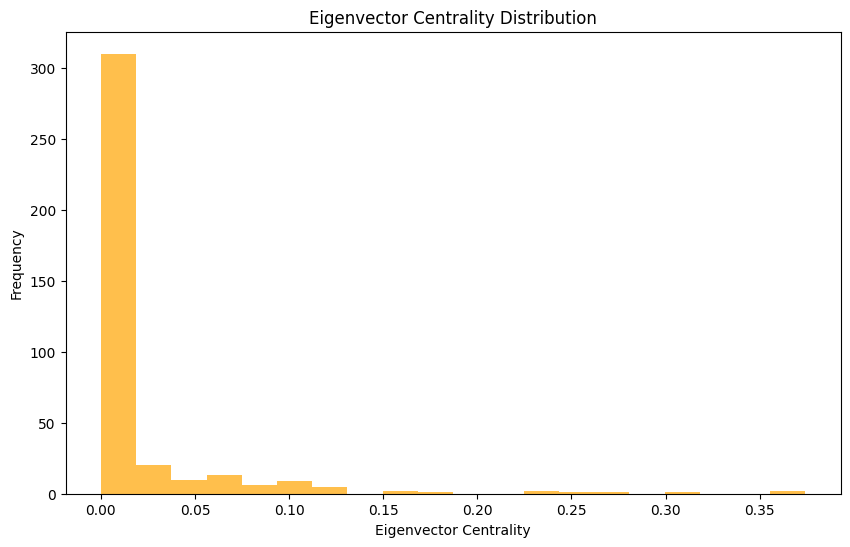

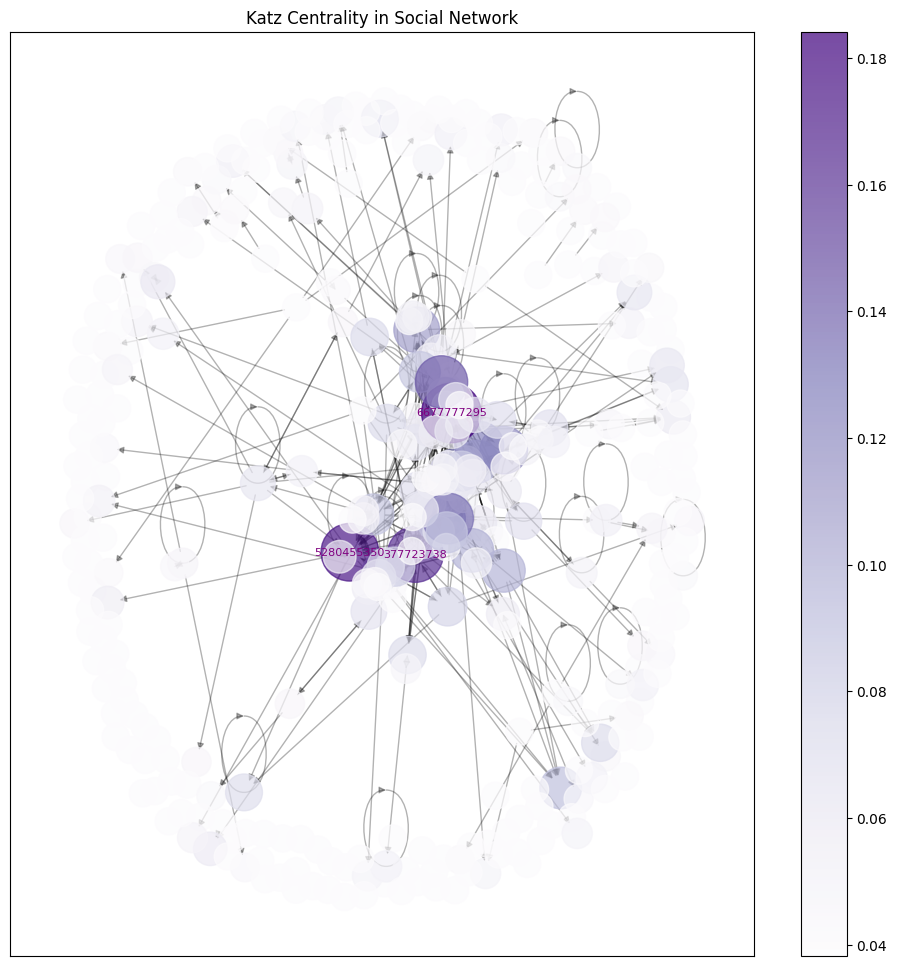

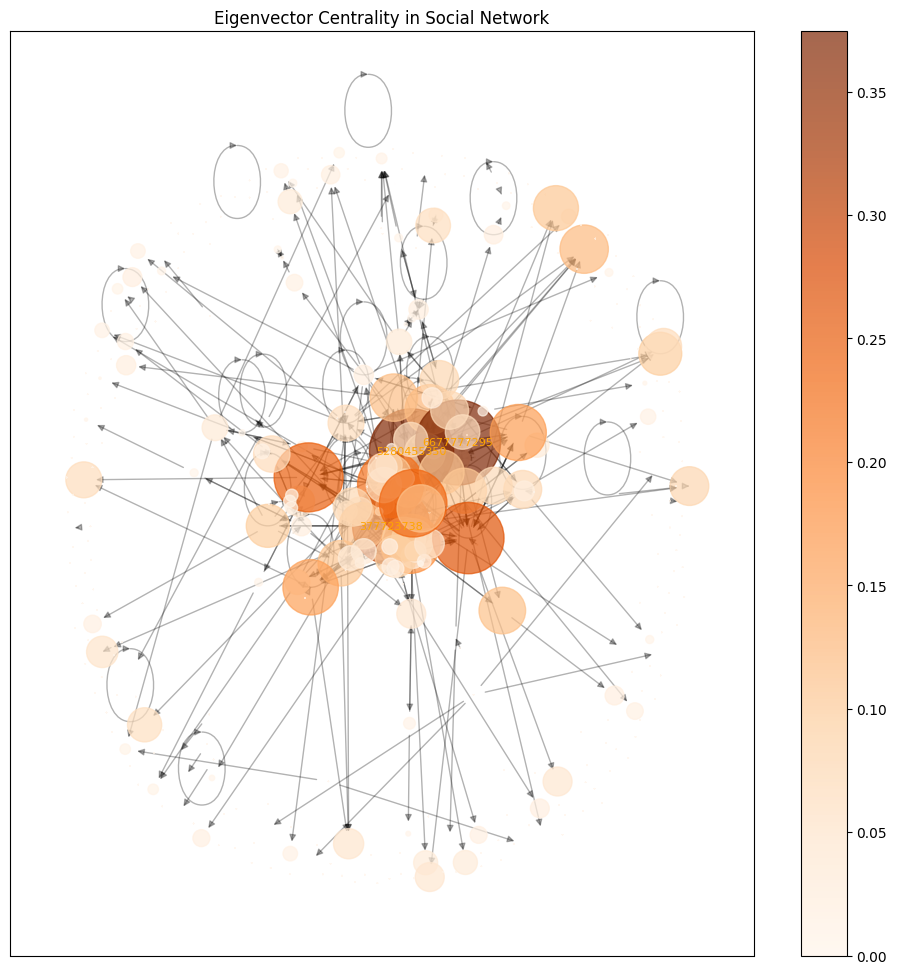

In [130]:
# Compute Katz and Eigenvector centralities
alpha = 0.1
beta = 1.0

katz_centrality = nx.katz_centrality(G_non_iso, alpha=alpha, beta=beta)
eigenvector_centrality = nx.eigenvector_centrality(G_non_iso)

# Create dataframes for centralities
centralities_df = pd.DataFrame({
    'Node': list(G_non_iso.nodes()),
    'Katz Centrality': list(katz_centrality.values()),
    'Eigenvector Centrality': list(eigenvector_centrality.values())
})

# Sort dataframes to get top nodes
top_katz_nodes = centralities_df.nlargest(10, 'Katz Centrality')
top_eigenvector_nodes = centralities_df.nlargest(10, 'Eigenvector Centrality')

# Print top nodes
print("Top 10 Nodes by Katz Centrality:")
print(top_katz_nodes)

print("\nTop 10 Nodes by Eigenvector Centrality:")
print(top_eigenvector_nodes)

# Function to plot histogram
def plot_histogram(centrality, title, color):
    plt.figure(figsize=(10, 6))
    plt.hist(list(centrality.values()), bins=20, color=color, alpha=0.7)
    plt.xlabel(title)
    plt.ylabel('Frequency')
    plt.title(f'{title} Distribution')
    plt.show()

# Plot Katz centrality
plot_histogram(katz_centrality, 'Katz Centrality', 'purple')

# Plot Eigenvector centrality
plot_histogram(eigenvector_centrality, 'Eigenvector Centrality', 'orange')

# Function to plot centrality measures in the graph
def plot_centrality_graph(G, centrality, title, cmap, color):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # Draw nodes with color map based on centralities
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=[v * 10000 for v in centrality.values()],
        cmap=cmap,
        node_color=list(centrality.values()),
        alpha=0.7
    )

    # Draw labels only for top 1% nodes
    top_1_percent = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:max(1, int(len(centrality) * 0.01))]
    labels = {node: node for node, _ in top_1_percent}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color=color)

    plt.colorbar(nodes)
    plt.title(title)
    plt.show()

# Plot centrality measures in the graph for Katz and Eigenvector centralities
plot_centrality_graph(G_non_iso, katz_centrality, 'Katz Centrality in Social Network', plt.cm.Purples, 'purple')
plot_centrality_graph(G_non_iso, eigenvector_centrality, 'Eigenvector Centrality in Social Network', plt.cm.Oranges, 'orange')


This code snippet computes and visualizes two additional centrality measures—Katz centrality and Eigenvector centrality—for the nodes in the social network graph (`G_non_iso`). Let's break down the code:

1. **Compute Katz and Eigenvector Centralities**:
   - Katz centrality and Eigenvector centrality are computed using the respective NetworkX functions: `nx.katz_centrality()` and `nx.eigenvector_centrality()`.
   - Appropriate values for parameters (alpha and beta) are chosen for Katz centrality.

2. **Create Dataframes for Centralities**:
   - Centralities are stored in a pandas DataFrame (`centralities_df`) for easy analysis and manipulation.

3. **Get Top Nodes**:
   - The top 10 nodes by Katz centrality and Eigenvector centrality are identified using the `nlargest()` function on the `centralities_df` DataFrame.

4. **Plot Centrality Distributions**:
   - Histograms are plotted to visualize the distributions of Katz centrality and Eigenvector centrality across the nodes in the graph.

5. **Visualize Centrality Measures in the Graph**:
   - For each centrality measure, a separate figure is created to visualize the centrality values of nodes in the graph.
   - Nodes are plotted with colors representing the centrality values using a color map.
   - Node sizes are adjusted based on centrality values to emphasize their importance in the network.
   - Node labels are added to enhance readability.
   - A color bar is included to indicate the mapping between node colors and centrality values.

These visualizations provide insights into the influence and importance of nodes within the social network based on Katz centrality and Eigenvector centrality measures.

Top 10 nodes by PageRank Centrality:
           Node  PageRank Centrality
142  6677777295             0.020794
223  6221209474             0.016948
254  6739926513             0.016561
89    858581486             0.016228
71    377723738             0.015446
59    813429682             0.015185
61   1865805661             0.014888
252  5698876479             0.014558
63   1238300528             0.014017
74   6723773271             0.013879
Top 10 nodes by HITS Hubs Centrality:
           Node  HITS Hubs Centrality
71    377723738              0.078576
226  5395904574              0.066410
142  6677777295              0.056771
69   5280455350              0.040698
121   538550024              0.034838
80   5962347019              0.032957
254  6739926513              0.032890
234  5547910904              0.029550
89    858581486              0.027118
227  6579989057              0.024127
Top 10 nodes by HITS Authorities Centrality:
           Node  HITS Authorities Centrality
142  66777

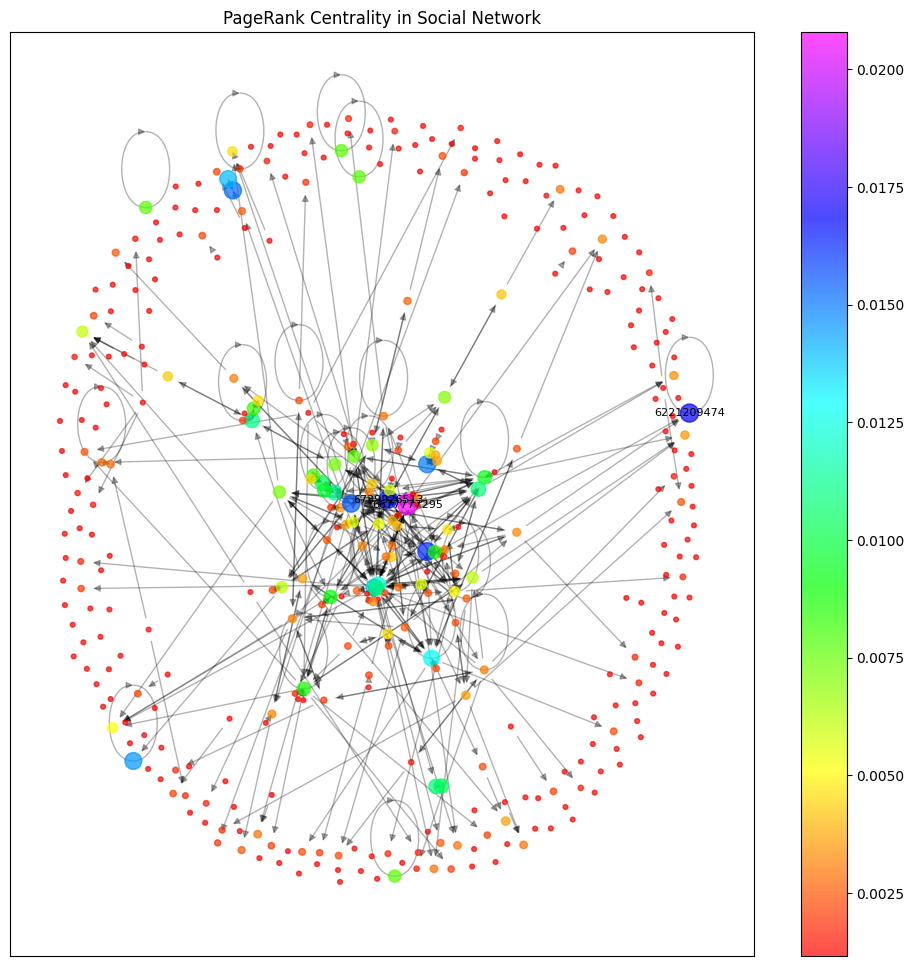

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


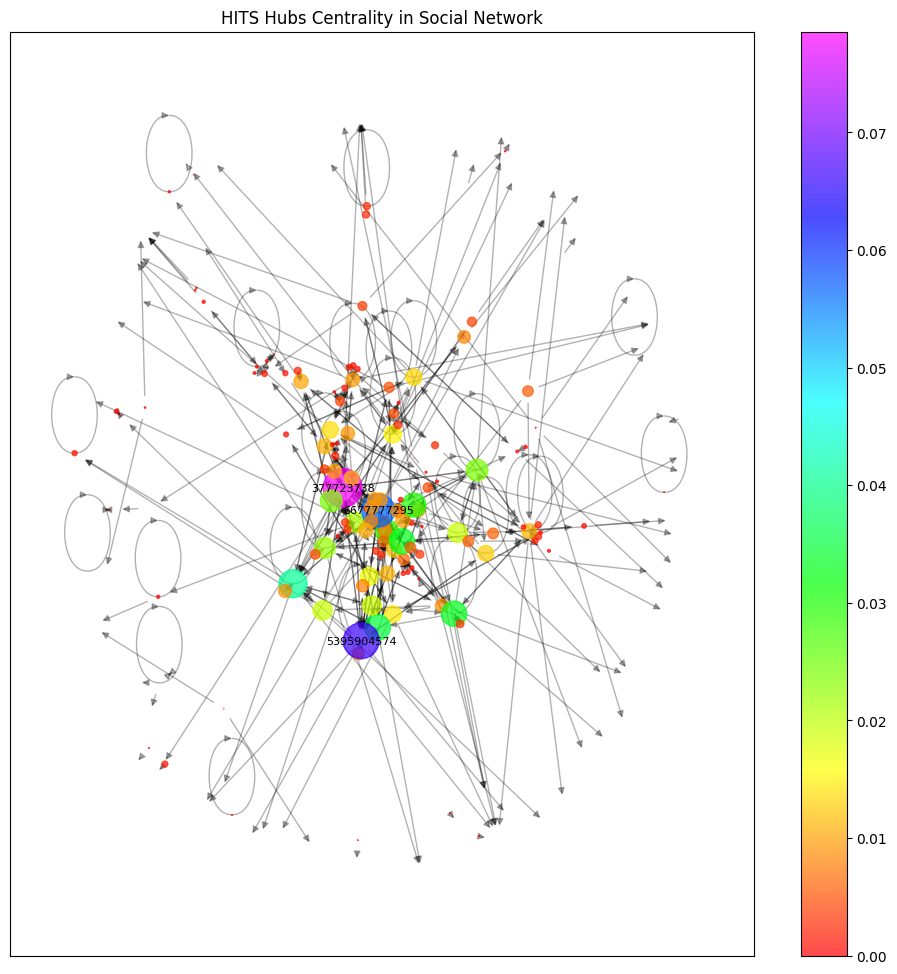

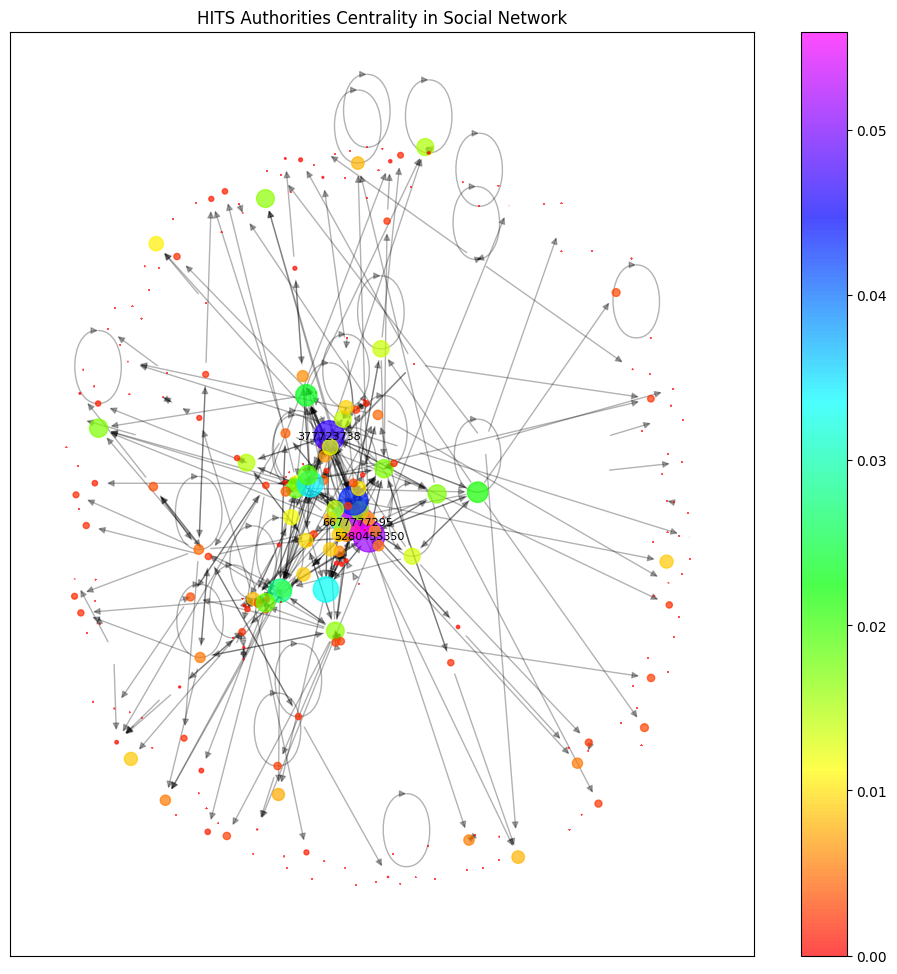

In [131]:

# Convert to directed graph
G_directed = G_non_iso.to_directed()

# Compute centralities
pagerank_centrality = nx.pagerank(G_directed)
hits_hubs, hits_authorities = nx.hits(G_directed)

# Create dataframes for centralities
pagerank_df = pd.DataFrame({
    'Node': list(G_directed.nodes()),
    'PageRank Centrality': list(pagerank_centrality.values())
})

hits_hubs_df = pd.DataFrame({
    'Node': list(G_directed.nodes()),
    'HITS Hubs Centrality': list(hits_hubs.values())
})

hits_authorities_df = pd.DataFrame({
    'Node': list(G_directed.nodes()),
    'HITS Authorities Centrality': list(hits_authorities.values())
})

# Display top nodes for PageRank Centrality
top_pagerank_nodes = pagerank_df.sort_values(by='PageRank Centrality', ascending=False).head(10)
print("Top 10 nodes by PageRank Centrality:")
print(top_pagerank_nodes)

# Display top nodes for HITS Hubs Centrality
top_hits_hubs_nodes = hits_hubs_df.sort_values(by='HITS Hubs Centrality', ascending=False).head(10)
print("Top 10 nodes by HITS Hubs Centrality:")
print(top_hits_hubs_nodes)

# Display top nodes for HITS Authorities Centrality
top_hits_authorities_nodes = hits_authorities_df.sort_values(by='HITS Authorities Centrality', ascending=False).head(10)
print("Top 10 nodes by HITS Authorities Centrality:")
print(top_hits_authorities_nodes)

# Function to create a rainbow colormap
def create_rainbow_colormap():
    colors = [(1, 0, 0), (1, 1, 0), (0, 1, 0), (0, 1, 1), (0, 0, 1), (1, 0, 1)]  # Red to violet
    cmap = mcolors.LinearSegmentedColormap.from_list("Rainbow", colors)
    return cmap

# Function to plot centrality measures in the graph
def plot_centrality_graph(G, centrality, title, colormap):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # Draw nodes with color map based on centralities
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=[v * 10000 for v in centrality.values()],
        cmap=colormap,
        node_color=list(centrality.values()),
        alpha=0.7
    )

    # Draw labels only for top 1% nodes
    top_1_percent = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:max(1, int(len(centrality) * 0.01))]
    labels = {node: node for node, _ in top_1_percent}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    plt.colorbar(nodes)
    plt.title(title)
    plt.show()

# Create rainbow colormap
rainbow_colormap = create_rainbow_colormap()

# Plot centrality measures in the graph for PageRank and HITS centralities
plot_centrality_graph(G_directed, pagerank_centrality, 'PageRank Centrality in Social Network', rainbow_colormap)
plot_centrality_graph(G_directed, hits_hubs, 'HITS Hubs Centrality in Social Network', rainbow_colormap)
plot_centrality_graph(G_directed, hits_authorities, 'HITS Authorities Centrality in Social Network', rainbow_colormap)

Based on the information retrieved from the group chat, we can infer several things:

1. **PageRank Centrality**: Nodes with high PageRank Centrality, such as '6677777295' and '6221209474', are likely to be influential members in the group chat. They may have a large number of connections or interactions with other members, contributing to their high importance.

2. **HITS Hubs Centrality**: Nodes identified as important hubs, like '377723738' and '5395904574', are likely to be active participants who frequently initiate or contribute to discussions. They may serve as central points for information dissemination within the group.

3. **HITS Authorities Centrality**: Nodes with high Authorities Centrality, such as '6677777295' and '5280455350', are likely to be respected or trusted members whose opinions or contributions are valued by others. They may act as sources of reliable information or have significant influence over group decisions.

Overall, analyzing centrality measures in the context of a group chat can provide insights into the dynamics of communication, identify key members, and understand the flow of information within the group.

In [132]:

def jaccard_similarity(G, node1, node2):
    neighbors1 = set(G.neighbors(node1))
    neighbors2 = set(G.neighbors(node2))
    intersection = len(neighbors1 & neighbors2)
    union = len(neighbors1 | neighbors2)
    return intersection / union if union != 0 else 0

# Compute Jaccard similarity for all pairs of nodes
node_pairs = combinations(G_non_iso.nodes(), 2)
jaccard_similarities = [
    (node1, node2, jaccard_similarity(G_non_iso, node1, node2))
    for node1, node2 in node_pairs
]

# Convert to DataFrame for easier viewing
jaccard_df = pd.DataFrame(jaccard_similarities, columns=['Node1', 'Node2', 'Jaccard Similarity'])
print("Jaccard Similarities:")
print(jaccard_df.sort_values(by='Jaccard Similarity', ascending=False).head(10))

Jaccard Similarities:
            Node1       Node2  Jaccard Similarity
37771  1546677221  5926109003                 1.0
67797  5831486344  5473919673                 1.0
66943  2120103452   475568330                 1.0
16795  1462417785   407023219                 1.0
7823   6092923100   605086799                 1.0
66165  6835478944   338889386                 1.0
16701  1462417785  2146933543                 1.0
51953  1862710217   338889386                 1.0
58540  2146933543   407023219                 1.0
30672  5961720399  5944785228                 1.0


In [133]:
# Create adjacency matrix
adj_matrix = nx.to_numpy_array(G_non_iso)

# Compute cosine similarity for adjacency matrix
cosine_sim = cosine_similarity(adj_matrix)

# Create a DataFrame for easier viewing
cosine_sim_df = pd.DataFrame(cosine_sim, index=G_non_iso.nodes(), columns=G_non_iso.nodes())
print("Cosine Similarities:")
print(cosine_sim_df.head(10))

Cosine Similarities:
                  1702975753  roductiveyouth  6658147168  port              \
1702975753               1.0             0.0         0.0               0.0   
roductiveyouth           0.0             0.0         0.0               0.0   
6658147168               0.0             0.0         1.0               0.0   
port                     0.0             0.0         0.0               0.0   
552752454                0.0             0.0         0.0               0.0   
utterBegin               0.0             0.0         0.0               0.0   
671901079                0.0             0.0         0.0               0.0   
1050906723               0.0             0.0         0.0               0.0   
401339144                0.0             0.0         0.0               0.0   
1244615555               0.0             0.0         0.0               0.0   

                  552752454  utterBegin  671901079  1050906723  401339144  \
1702975753              0.0         0.0    

This code snippet generates and visualizes various similarity matrices for the social network graph (`G_non_iso`). Here's how it works:

1. **Similarity Matrices Generation**:
   - The `sim_matrices()` function calculates four similarity matrices: the adjacency matrix (`A`), Pearson correlation coefficient matrix (`corr`), Jaccard similarity matrix (`J`), and cosine similarity matrix (`cos`).
   - Each matrix captures different aspects of relationships or similarities between nodes in the graph.

2. **Reverse Cuthill-McKee Ordering**:
   - The `cm_order()` function computes the Reverse Cuthill-McKee ordering for the adjacency matrix. This reordering technique aims to minimize the bandwidth of the adjacency matrix, leading to more efficient matrix operations and improved visual clarity.

3. **Plotting Similarity Matrices**:
   - The similarity matrices and their reordered versions are plotted using `matplotlib` and `seaborn` libraries.
   - Each subplot displays a heatmap of a similarity matrix, with titles indicating the type of similarity and whether it's ordered or not.

4. **Visualizing Different Types of Similarity**:
   - The matrices include the adjacency matrix, Pearson correlation coefficient matrix, Jaccard similarity matrix, and cosine similarity matrix.
   - The reordered versions provide insights into the structure of the graph and the relationships between nodes after applying the Reverse Cuthill-McKee ordering.

These visualizations offer valuable insights into the relationships and similarities between nodes in the social network graph, facilitating further analysis and interpretation.

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Figure size 1200x2400 with 0 Axes>

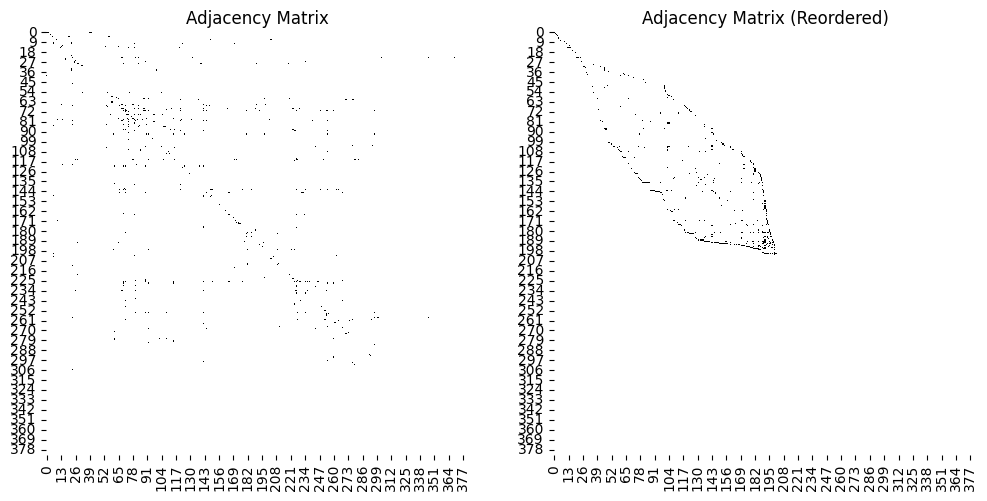

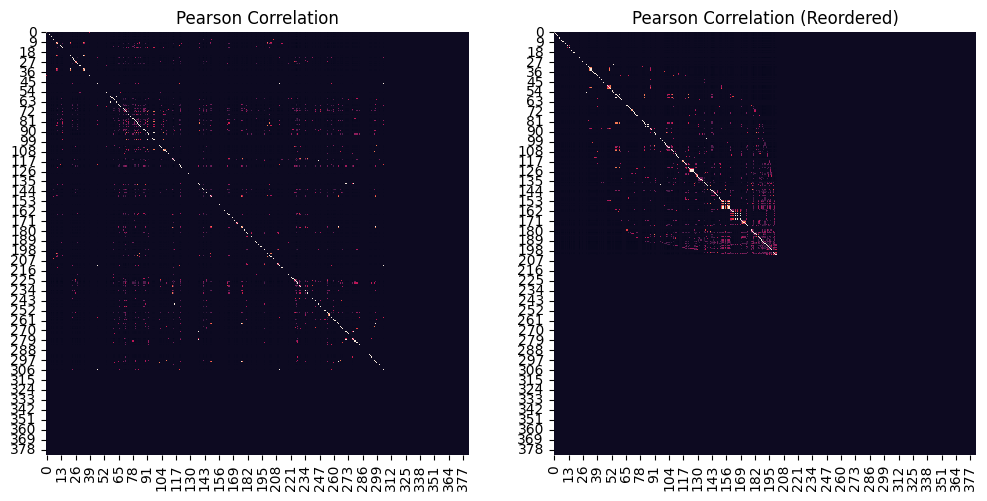

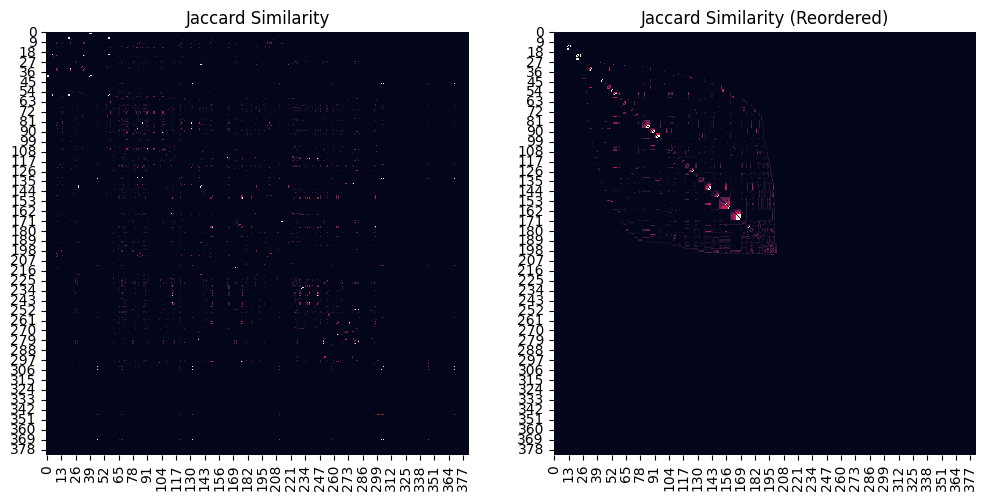

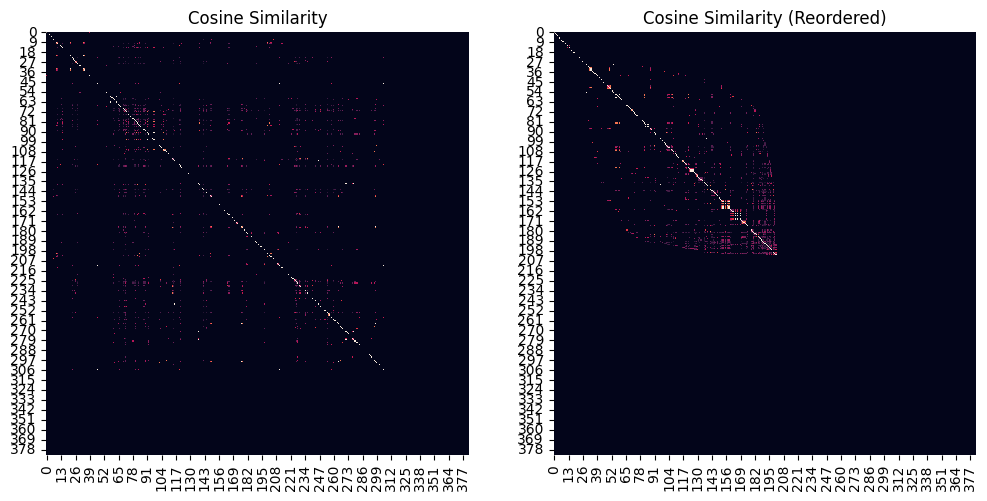

In [134]:
# Function to calculate similarity matrices
def sim_matrices(G):
    A = nx.to_numpy_array(G)
    pc = np.corrcoef(A)
    pc = np.nan_to_num(pc, nan=0.0)  # Replace NaN values with 0
    J = np.zeros(A.shape)
    for i, j, c in nx.jaccard_coefficient(nx.from_numpy_array(A)):
        J[i, j] = c
        J[j, i] = c  # Jaccard similarity is symmetric

    cs = cosine_similarity(A)

    return A, pc, J, cs

# Function to compute Reverse Cuthill-McKee ordering
def cm_order(G):
    adj_matrix = nx.to_scipy_sparse_array(G)
    order = reverse_cuthill_mckee(adj_matrix)
    return order

# Generate the similarity matrices
A, corr, J, cos = sim_matrices(G_non_iso)
order = cm_order(G_non_iso)

# Plot the similarity matrices and their reordered versions
fig = plt.figure(figsize=(12, 24))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

cases = [
    [1, A, plt.cm.Greys, 'Adjacency Matrix', range(len(G_non_iso.nodes()))],
    [2, A, plt.cm.Greys, 'Adjacency Matrix (Reordered)', order],
    [3, corr, None, 'Pearson Correlation', range(len(G_non_iso.nodes()))],
    [4, corr, None, 'Pearson Correlation (Reordered)', order],
    [5, J, None, 'Jaccard Similarity', range(len(G_non_iso.nodes()))],
    [6, J, None, 'Jaccard Similarity (Reordered)', order],
    [7, cos, None, 'Cosine Similarity', range(len(G_non_iso.nodes()))],
    [8, cos, None, 'Cosine Similarity (Reordered)', order]
]

# Plot the similarity matrices and their reordered versions in pairs
for i in range(0, len(cases), 2):
    fig = plt.figure(figsize=(12, 8))

    # Plot the first matrix
    plt.subplot(1, 2, 1)
    matrix_1, cmap_1, title_1, order_1 = cases[i][1], cases[i][2], cases[i][3], cases[i][4]
    sns.heatmap(matrix_1[np.ix_(order_1, order_1)], cmap=cmap_1, cbar=False, square=True)
    plt.title(title_1)

    # Plot the second matrix if available
    if i + 1 < len(cases):
        plt.subplot(1, 2, 2)
        matrix_2, cmap_2, title_2, order_2 = cases[i+1][1], cases[i+1][2], cases[i+1][3], cases[i+1][4]
        sns.heatmap(matrix_2[np.ix_(order_2, order_2)], cmap=cmap_2, cbar=False, square=True)
        plt.title(title_2)

    plt.show()


plt.show()

This code snippet finds all maximal cliques in the connected graph `G_connected` and visualizes them within the network. Here's what it does:

1. **Finding Maximal Cliques**:
   - The `nx.find_cliques()` function identifies all maximal cliques in the connected graph `G_connected`.
   - Maximal cliques are complete subgraphs where every node is connected to every other node within the subgraph.

2. **Printing the Number of Cliques**:
   - The code prints the total number of cliques found in the graph.

3. **Visualizing the Cliques**:
   - A matplotlib figure is created with a spring layout for the network visualization.
   - Nodes in the graph are initially drawn with light blue color and bold labels.
   - Then, nodes belonging to each clique are highlighted separately with a salmon color to distinguish them from the rest of the network.

This visualization helps to identify densely connected subgroups within the communication network, providing insights into how individuals or entities are clustered together based on their interactions.

Number of cliques found: 392


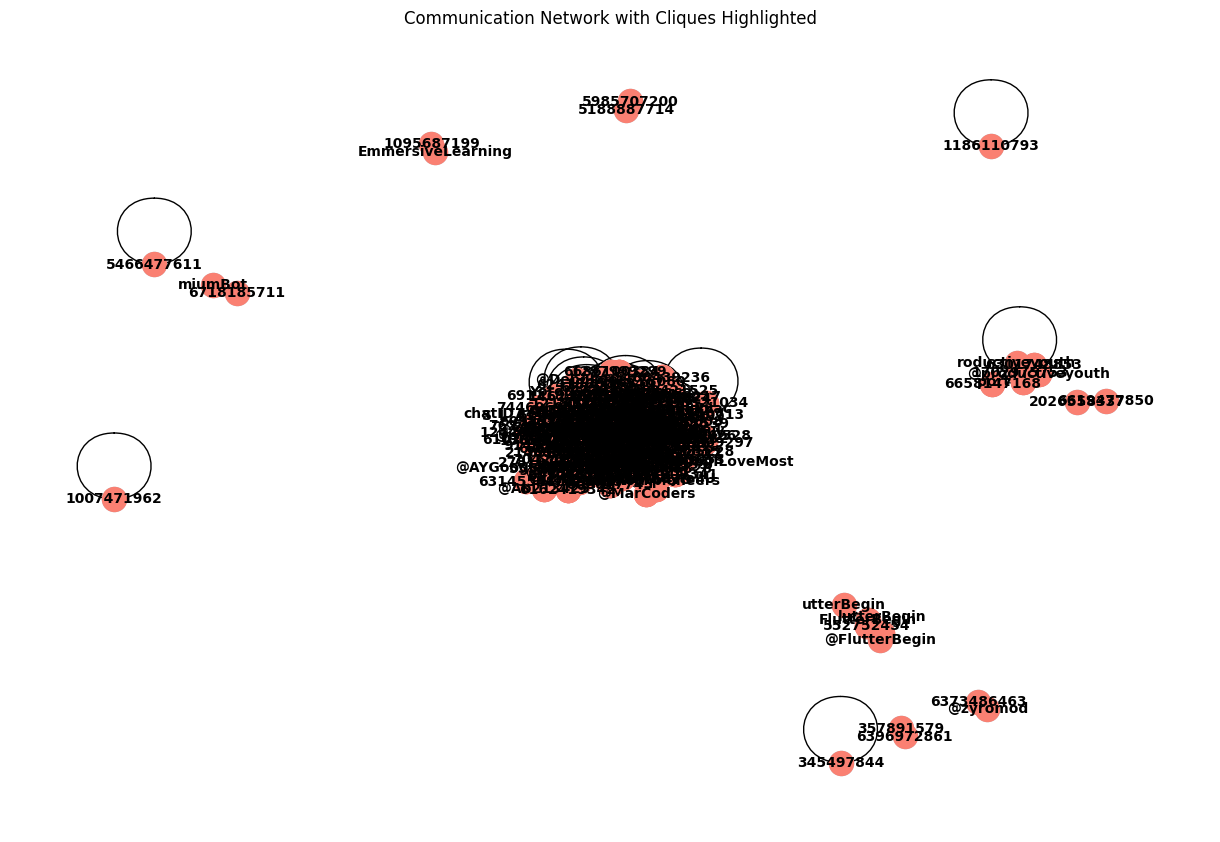

In [135]:

# Find all maximal cliques in the graph
cliques = list(nx.find_cliques(G_connected))

# Print the number of cliques found
print(f"Number of cliques found: {len(cliques)}")

# Visualize the cliques
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_connected)
nx.draw(G_connected, pos, with_labels=True, node_color='lightblue', node_size=300, font_size=10, font_weight='bold')

# Draw nodes for each clique separately to highlight them
for clique in cliques:
    nx.draw_networkx_nodes(G_connected, pos, nodelist=clique, node_color='salmon', node_size=300)

plt.title('Communication Network with Cliques Highlighted')
plt.show()